### Impoting Libraries

In [2]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report, accuracy_score, roc_auc_score, precision_score, recall_score, f1_score
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import RFE
import joblib  # For saving/loading models
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

C:\Users\Pir Bakhsh\AppData\Roaming\Python\Python311\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


### Loading Dataset 

In [3]:
# Load the dataset
file_path = 'diabetes_binary_health_indicators_BRFSS2015.csv'  # Replace with your file path
df = pd.read_csv(file_path)

In [4]:
df.head()

Diabetes_binary  HighBP  HighChol  CholCheck   BMI  Smoker  Stroke  \
0              0.0     1.0       1.0        1.0  40.0     1.0     0.0   
1              0.0     0.0       0.0        0.0  25.0     1.0     0.0   
2              0.0     1.0       1.0        1.0  28.0     0.0     0.0   
3              0.0     1.0       0.0        1.0  27.0     0.0     0.0   
4              0.0     1.0       1.0        1.0  24.0     0.0     0.0   

   HeartDiseaseorAttack  PhysActivity  Fruits  ...  AnyHealthcare  \
0                   0.0           0.0     0.0  ...            1.0   
1                   0.0           1.0     0.0  ...            0.0   
2                   0.0           0.0     1.0  ...            1.0   
3                   0.0           1.0     1.0  ...            1.0   
4                   0.0           1.0     1.0  ...            1.0   

   NoDocbcCost  GenHlth  MentHlth  PhysHlth  DiffWalk  Sex   Age  Education  \
0          0.0      5.0      18.0      15.0       1.0  0.0   9.0        4.0   
1          1.0      3.0       0.0       0.0       0.0  0.0   7.0        6.0   
2          1.0      5.0      30.0      30.0       1.0  0.0   9.0        4.0   
3          0.0      2.0       0.0       0.0       0.0  0.0  11.0        3.0   
4          0.0      2.0       3.0       0.0       0.0  0.0  11.0        5.0   

   Income  
0     3.0  
1     1.0  
2     8.0  
3     6.0  
4     4.0  

[5 rows x 22 columns]

### Data Preprocessing & Balancing

In [5]:
# Handle missing values (imputation)
imputer = SimpleImputer(strategy='median')
df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

# Separate features and target variable
X = df_imputed.drop('Diabetes_binary', axis=1)
y = df_imputed['Diabetes_binary']

# Normalize or scale the data
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Apply SMOTE for balancing the dataset
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X_scaled, y)

### Spliting data into train, test and validation 

In [6]:
# Split the dataset into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X_smote, y_smote, test_size=0.3, random_state=42, stratify=y_smote)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Check the balanced class distribution in the resampled dataset
print("Balanced class distribution in training set:")
print(y_train.value_counts())

Balanced class distribution in training set:
Diabetes_binary
1.0    152834
0.0    152833
Name: count, dtype: int64


In [7]:
# Display the shape of training, validation, and testing sets
print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)
print("Testing set shape:", X_test.shape)

Training set shape: (305667, 21)
Validation set shape: (65500, 21)
Testing set shape: (65501, 21)


## XGBoost for Diabetes Prediction

In [7]:
# Initialize the XGBoost model
xgb_model = XGBClassifier(random_state=42)

model_path = "best_xgb_model.pkl"

# Set up Hyperparameter Tuning for XGBoost
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 0.1, 0.2],
    'reg_alpha': [0, 0.01, 0.1],
    'reg_lambda': [1, 1.5, 2],
}

# Randomized Search for XGBoost Hyperparameters
random_search_xgb = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_grid, 
                                       n_iter=10, cv=3, verbose=2, random_state=42, n_jobs=-1)

# Fit the model to training data
random_search_xgb.fit(X_train, y_train)

# Best parameters after search
best_params_xgb = random_search_xgb.best_params_
print(f"Best hyperparameters for XGBoost: {best_params_xgb}")

# Save the best model found by RandomizedSearchCV
best_xgb_model = random_search_xgb.best_estimator_
joblib.dump(best_xgb_model, model_path)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best hyperparameters for XGBoost: {'subsample': 0.8, 'reg_lambda': 2, 'reg_alpha': 0.1, 'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.1, 'gamma': 0.2, 'colsample_bytree': 0.8}


['best_xgb_model.pkl']

### Evaluating XGBoost 

In [8]:
# Evaluate the best XGBoost model on the validation set
y_val_pred_xgb = best_xgb_model.predict(X_val)
y_val_prob_xgb = best_xgb_model.predict_proba(X_val)[:, 1]  # For ROC-AUC calculation

# Evaluate metrics
accuracy_xgb = accuracy_score(y_val, y_val_pred_xgb)
roc_auc_xgb = roc_auc_score(y_val, y_val_prob_xgb)
classification_rep_xgb = classification_report(y_val, y_val_pred_xgb)

# Print evaluation metrics
print(f"XGBoost Validation Accuracy: {accuracy_xgb}")
print(f"XGBoost Validation ROC-AUC: {roc_auc_xgb}")
print("Classification Report for XGBoost:\n", classification_rep_xgb)


XGBoost Validation Accuracy: 0.9161832061068702
XGBoost Validation ROC-AUC: 0.9689721615290484
Classification Report for XGBoost:
               precision    recall  f1-score   support

         0.0       0.87      0.97      0.92     32750
         1.0       0.97      0.86      0.91     32750

    accuracy                           0.92     65500
   macro avg       0.92      0.92      0.92     65500
weighted avg       0.92      0.92      0.92     65500



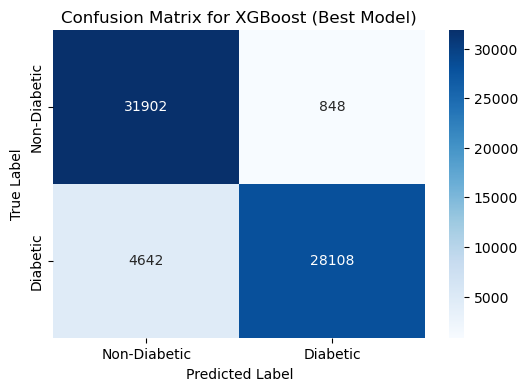

In [9]:
# Confusion Matrix for XGBoost (using best_xgb_model)
cm_xgb = confusion_matrix(y_val, y_val_pred_xgb)

# Plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm_xgb, annot=True, fmt="d", cmap="Blues", 
            xticklabels=['Non-Diabetic', 'Diabetic'], 
            yticklabels=['Non-Diabetic', 'Diabetic'])
plt.title('Confusion Matrix for XGBoost (Best Model)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

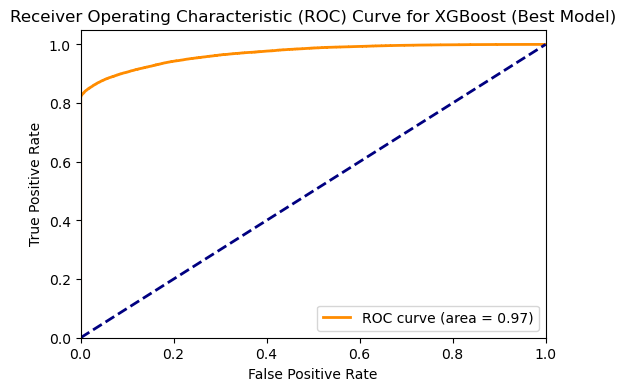

In [10]:
# ROC Curve for XGBoost (using best_xgb_model)
fpr_xgb, tpr_xgb, _ = roc_curve(y_val, y_val_prob_xgb)  # Using probability predictions from the best XGBoost model
roc_auc = auc(fpr_xgb, tpr_xgb)

# Plot the ROC Curve
plt.figure(figsize=(6, 4))
plt.plot(fpr_xgb, tpr_xgb, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for XGBoost (Best Model)')
plt.legend(loc="lower right")
plt.show()

### Testing XGBoost 

In [11]:
# Run the best XGBoost model on test data
y_test_pred_xgb = best_xgb_model.predict(X_test)  # Predict using the best XGBoost model
y_test_prob_xgb = best_xgb_model.predict_proba(X_test)[:, 1]  # Probability for ROC-AUC calculation on test data

# Evaluate metrics on the test set
test_accuracy_xgb = accuracy_score(y_test, y_test_pred_xgb)
test_roc_auc_xgb = roc_auc_score(y_test, y_test_prob_xgb)
test_classification_rep_xgb = classification_report(y_test, y_test_pred_xgb)

# Print the results
print(f"XGBoost Test Accuracy: {test_accuracy_xgb}")
print(f"XGBoost Test ROC-AUC: {test_roc_auc_xgb}")
print("Classification Report for XGBoost on Test Set:\n", test_classification_rep_xgb)


XGBoost Test Accuracy: 0.9181233874291995
XGBoost Test ROC-AUC: 0.9707757949701904
Classification Report for XGBoost on Test Set:
               precision    recall  f1-score   support

         0.0       0.88      0.97      0.92     32751
         1.0       0.97      0.86      0.91     32750

    accuracy                           0.92     65501
   macro avg       0.92      0.92      0.92     65501
weighted avg       0.92      0.92      0.92     65501



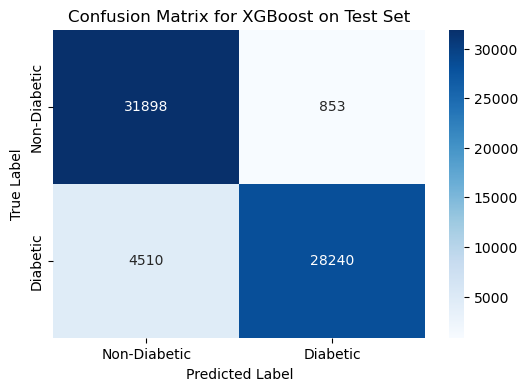

In [12]:
# Confusion Matrix for XGBoost on the test set
cm_test_xgb = confusion_matrix(y_test, y_test_pred_xgb)

# Plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm_test_xgb, annot=True, fmt="d", cmap="Blues", 
            xticklabels=['Non-Diabetic', 'Diabetic'], 
            yticklabels=['Non-Diabetic', 'Diabetic'])

plt.title('Confusion Matrix for XGBoost on Test Set')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


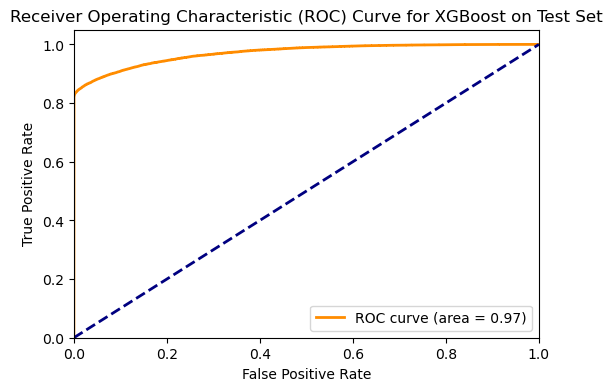

In [13]:
# ROC Curve for XGBoost on the test set
fpr_test_xgb, tpr_test_xgb, _ = roc_curve(y_test, y_test_prob_xgb)
roc_auc_test_xgb = auc(fpr_test_xgb, tpr_test_xgb)

# Plot ROC Curve for XGBoost on Test Set
plt.figure(figsize=(6, 4))
plt.plot(fpr_test_xgb, tpr_test_xgb, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_test_xgb:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for XGBoost on Test Set')
plt.legend(loc="lower right")
plt.show()

### Random Forest for Diabetes Prediction

In [14]:
# Define model save path
model_path_rf = "rf_model.pkl"

# Perform Feature Selection using Recursive Feature Elimination (RFE)
rfe_selector = RFE(RandomForestClassifier(random_state=42), n_features_to_select=10)
rfe_selector = rfe_selector.fit(X_train, y_train)

# Transform the data to reduce features based on RFE selection
X_train_reduced = rfe_selector.transform(X_train)
X_val_reduced = rfe_selector.transform(X_val)

# Define parameter grid for hyperparameter tuning
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Initialize Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Set up Hyperparameter Tuning using RandomizedSearchCV
random_search_rf = RandomizedSearchCV(estimator=rf_model, param_distributions=param_grid_rf, 
                                      n_iter=10, cv=3, verbose=2, random_state=42, n_jobs=-1)

# Perform hyperparameter tuning on the reduced training set
random_search_rf.fit(X_train_reduced, y_train)

# Save the best model to a file
best_rf_model = random_search_rf.best_estimator_  # Assign the best model to a variable
joblib.dump(best_rf_model, model_path_rf)

# Print best hyperparameters
best_params_rf = random_search_rf.best_params_
print(f"Best hyperparameters for Random Forest: {best_params_rf}")

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best hyperparameters for Random Forest: {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_depth': None, 'bootstrap': False}


### Evaluating Random Forest 

In [15]:
# Use the best model (best_rf_model) for predictions
y_val_pred_rf = best_rf_model.predict(X_val_reduced)
y_val_prob_rf = best_rf_model.predict_proba(X_val_reduced)[:, 1]  # For ROC-AUC calculation

# Evaluate the model on the validation set
val_accuracy_rf = accuracy_score(y_val, y_val_pred_rf)
val_roc_auc_rf = roc_auc_score(y_val, y_val_prob_rf)
val_classification_report_rf = classification_report(y_val, y_val_pred_rf)

# Print evaluation metrics
print(f"Random Forest Validation Accuracy: {val_accuracy_rf}")
print(f"Random Forest Validation ROC-AUC: {val_roc_auc_rf}")
print("Classification Report for Random Forest on Validation Set:")
print(val_classification_report_rf)

Random Forest Validation Accuracy: 0.9098167938931297
Random Forest Validation ROC-AUC: 0.9661720282034846
Classification Report for Random Forest on Validation Set:
              precision    recall  f1-score   support

         0.0       0.88      0.95      0.91     32750
         1.0       0.94      0.87      0.91     32750

    accuracy                           0.91     65500
   macro avg       0.91      0.91      0.91     65500
weighted avg       0.91      0.91      0.91     65500



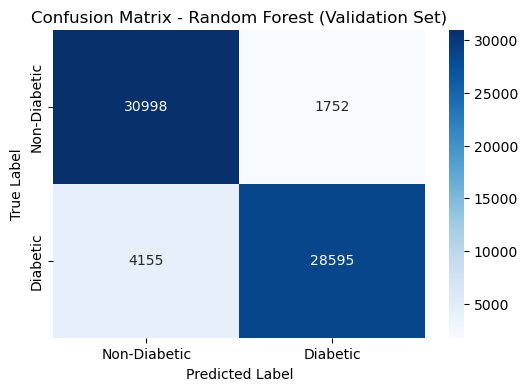

In [16]:
# Confusion Matrix for validation set using best_rf_model
cm_rf = confusion_matrix(y_val, y_val_pred_rf)  # Use predictions from best_rf_model
plt.figure(figsize=(6, 4))
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Blues", xticklabels=['Non-Diabetic', 'Diabetic'], yticklabels=['Non-Diabetic', 'Diabetic'])
plt.title('Confusion Matrix - Random Forest (Validation Set)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

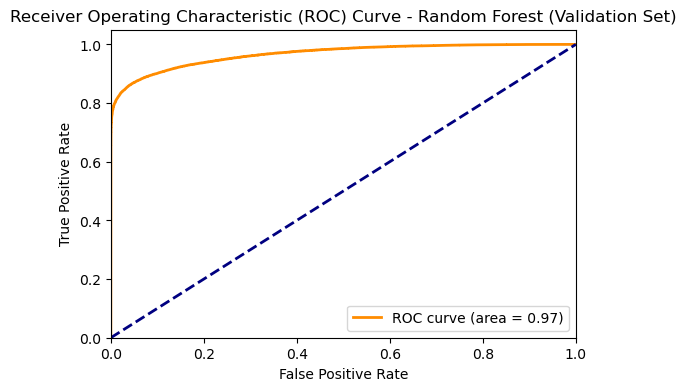

In [17]:
# ROC Curve for validation set using best_rf_model
fpr_rf, tpr_rf, _ = roc_curve(y_val, y_val_prob_rf)  # Use probabilities from best_rf_model
roc_auc_rf = auc(fpr_rf, tpr_rf)

plt.figure(figsize=(6, 4))
plt.plot(fpr_rf, tpr_rf, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_rf:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Random Forest (Validation Set)')
plt.legend(loc="lower right")
plt.show()

### Testing Random Forest

In [25]:
best_rf_model = joblib.load(model_path_rf)

X_test_reduced = rfe_selector.transform(X_test)  # Ensure you have X_test defined

y_test_pred_rf = best_rf_model.predict(X_test_reduced)
y_test_prob_rf = best_rf_model.predict_proba(X_test_reduced)[:, 1]  # For ROC-AUC calculation

test_accuracy_rf = accuracy_score(y_test, y_test_pred_rf)
test_roc_auc_rf = roc_auc_score(y_test, y_test_prob_rf)
test_classification_rep_rf = classification_report(y_test, y_test_pred_rf)

print(f"Random Forest Test Accuracy: {test_accuracy_rf:.4f}")
print(f"Random Forest Test ROC-AUC: {test_roc_auc_rf:.4f}")
print("Random Forest Test Classification Report:")
print(test_classification_rep_rf)

Random Forest Test Accuracy: 0.9100
Random Forest Test ROC-AUC: 0.9676
Random Forest Test Classification Report:
              precision    recall  f1-score   support

         0.0       0.88      0.94      0.91     32751
         1.0       0.94      0.88      0.91     32750

    accuracy                           0.91     65501
   macro avg       0.91      0.91      0.91     65501
weighted avg       0.91      0.91      0.91     65501



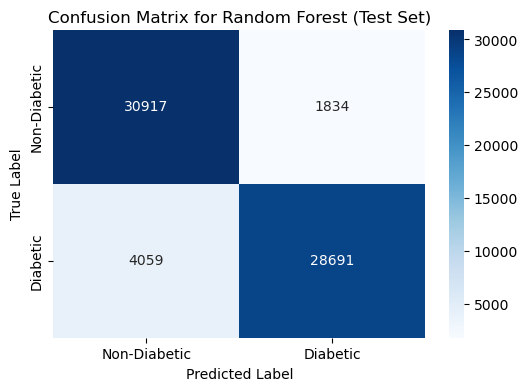

In [26]:
test_cm_rf = confusion_matrix(y_test, y_test_pred_rf)
plt.figure(figsize=(6, 4))
sns.heatmap(test_cm_rf, annot=True, fmt="d", cmap="Blues", xticklabels=['Non-Diabetic', 'Diabetic'], yticklabels=['Non-Diabetic', 'Diabetic'])
plt.title('Confusion Matrix for Random Forest (Test Set)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

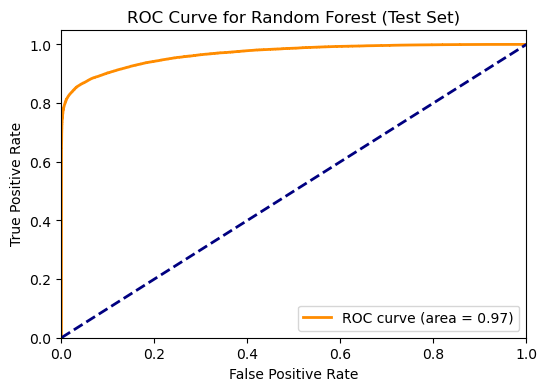

In [28]:
fpr_rf_test, tpr_rf_test, _ = roc_curve(y_test, y_test_prob_rf)
roc_auc_rf_test = auc(fpr_rf_test, tpr_rf_test)

plt.figure(figsize=(6, 4))
plt.plot(fpr_rf_test, tpr_rf_test, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_rf_test:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Random Forest (Test Set)')
plt.legend(loc="lower right")
plt.show()

## LightGBM for Diabetes Prediction

In [36]:
# Initialize the LightGBM model
lgb_model = LGBMClassifier(random_state=42)

model_path_lgb = "lgb_best_model.pkl"  # Update model path for best model

# Set up hyperparameter grid for tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0]
}

# Perform Grid Search with cross-validation (GridSearchCV)
grid_search_lgb = GridSearchCV(estimator=lgb_model, param_grid=param_grid, 
                               cv=3, verbose=2, n_jobs=-1)

# Fit the model to the training data
grid_search_lgb.fit(X_train, y_train)

# Save the best model
best_lgb_model = grid_search_lgb.best_estimator_
joblib.dump(best_lgb_model, model_path_lgb)  # Save the best model

# Best hyperparameters after search
best_params_lgb = grid_search_lgb.best_params_
print(f"Best hyperparameters for LightGBM: {best_params_lgb}")

Fitting 3 folds for each of 54 candidates, totalling 162 fits
[LightGBM] [Info] Number of positive: 152834, number of negative: 152833
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023996 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3960
[LightGBM] [Info] Number of data points in the train set: 305667, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500002 -> initscore=0.000007
[LightGBM] [Info] Start training from score 0.000007
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Lig

### Evaluating LightGBM 

In [37]:
# Evaluate the best LightGBM model
y_val_pred_lgb = best_lgb_model.predict(X_val)
y_val_prob_lgb = best_lgb_model.predict_proba(X_val)[:, 1]  # For ROC-AUC calculation
lgb_accuracy = accuracy_score(y_val, y_val_pred_lgb)

print(f"Best parameters for LightGBM: {grid_search_lgb.best_params_}")
print(f"LightGBM Accuracy: {lgb_accuracy:.4f}")
print("Classification Report for LightGBM:\n", classification_report(y_val, y_val_pred_lgb))

Best parameters for LightGBM: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 300, 'subsample': 0.8}
LightGBM Accuracy: 0.9186
Classification Report for LightGBM:
               precision    recall  f1-score   support

         0.0       0.88      0.98      0.92     32750
         1.0       0.97      0.86      0.91     32750

    accuracy                           0.92     65500
   macro avg       0.92      0.92      0.92     65500
weighted avg       0.92      0.92      0.92     65500



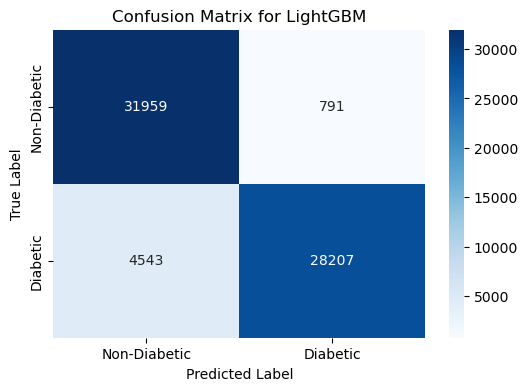

In [38]:
# Confusion matrix
cm_lgb = confusion_matrix(y_val, y_val_pred_lgb)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_lgb, annot=True, fmt="d", cmap="Blues", xticklabels=['Non-Diabetic', 'Diabetic'], yticklabels=['Non-Diabetic', 'Diabetic'])
plt.title('Confusion Matrix for LightGBM')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

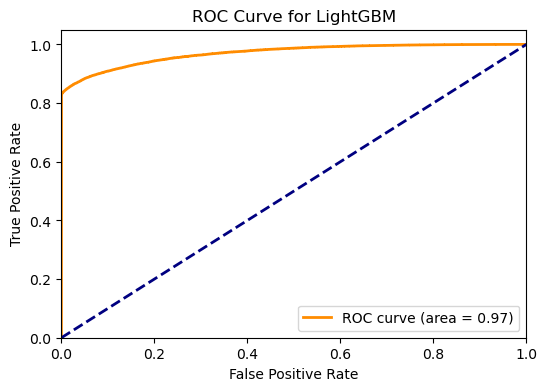

In [39]:
# ROC Curve
fpr_lgb, tpr_lgb, _ = roc_curve(y_val, y_val_prob_lgb)
roc_auc_lgb = auc(fpr_lgb, tpr_lgb)
plt.figure(figsize=(6, 4))
plt.plot(fpr_lgb, tpr_lgb, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_lgb:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for LightGBM')
plt.legend(loc="lower right")
plt.show()

### Testing LightGBM

In [40]:
# Testing the best LightGBM model on the test set
y_test_pred_lgb = best_lgb_model.predict(X_test)
y_test_prob_lgb = best_lgb_model.predict_proba(X_test)[:, 1]  # For ROC-AUC calculation

# Evaluate the model on the test set
lgb_test_accuracy = accuracy_score(y_test, y_test_pred_lgb)
lgb_test_precision = precision_score(y_test, y_test_pred_lgb)
lgb_test_recall = recall_score(y_test, y_test_pred_lgb)
lgb_test_f1 = f1_score(y_test, y_test_pred_lgb)
lgb_test_roc_auc = roc_auc_score(y_test, y_test_prob_lgb)

print(f"LightGBM Test Accuracy: {lgb_test_accuracy:.4f}")
print(f"LightGBM Test Precision: {lgb_test_precision:.4f}")
print(f"LightGBM Test Recall: {lgb_test_recall:.4f}")
print(f"LightGBM Test F1-Score: {lgb_test_f1:.4f}")
print(f"LightGBM Test ROC-AUC: {lgb_test_roc_auc:.4f}")
print("\nClassification Report for LightGBM Test Set:\n", classification_report(y_test, y_test_pred_lgb))

LightGBM Test Accuracy: 0.9203
LightGBM Test Precision: 0.9725
LightGBM Test Recall: 0.8650
LightGBM Test F1-Score: 0.9156
LightGBM Test ROC-AUC: 0.9716

Classification Report for LightGBM Test Set:
               precision    recall  f1-score   support

         0.0       0.88      0.98      0.92     32751
         1.0       0.97      0.86      0.92     32750

    accuracy                           0.92     65501
   macro avg       0.93      0.92      0.92     65501
weighted avg       0.93      0.92      0.92     65501



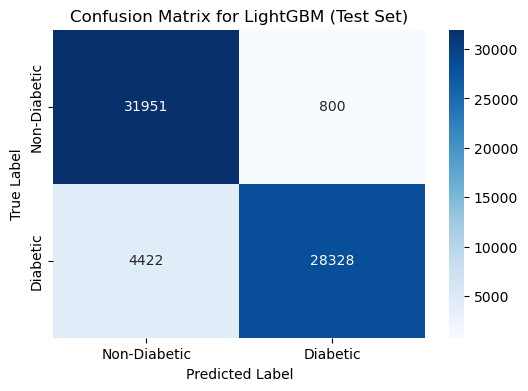

In [41]:
# Confusion Matrix for the test set
cm_lgb_test = confusion_matrix(y_test, y_test_pred_lgb)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_lgb_test, annot=True, fmt="d", cmap="Blues", 
            xticklabels=['Non-Diabetic', 'Diabetic'], 
            yticklabels=['Non-Diabetic', 'Diabetic'])
plt.title('Confusion Matrix for LightGBM (Test Set)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

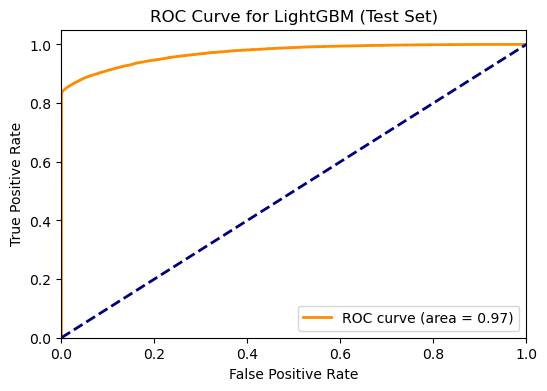

In [42]:
# ROC Curve for the test set
fpr_lgb_test, tpr_lgb_test, _ = roc_curve(y_test, y_test_prob_lgb)
roc_auc_lgb_test = auc(fpr_lgb_test, tpr_lgb_test)

plt.figure(figsize=(6, 4))
plt.plot(fpr_lgb_test, tpr_lgb_test, color='darkorange', lw=2, 
         label=f'ROC curve (area = {roc_auc_lgb_test:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for LightGBM (Test Set)')
plt.legend(loc="lower right")
plt.show()

[LightGBM] [Info] Number of positive: 152834, number of negative: 152833
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015320 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3960
[LightGBM] [Info] Number of data points in the train set: 305667, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500002 -> initscore=0.000007
[LightGBM] [Info] Start training from score 0.000007
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

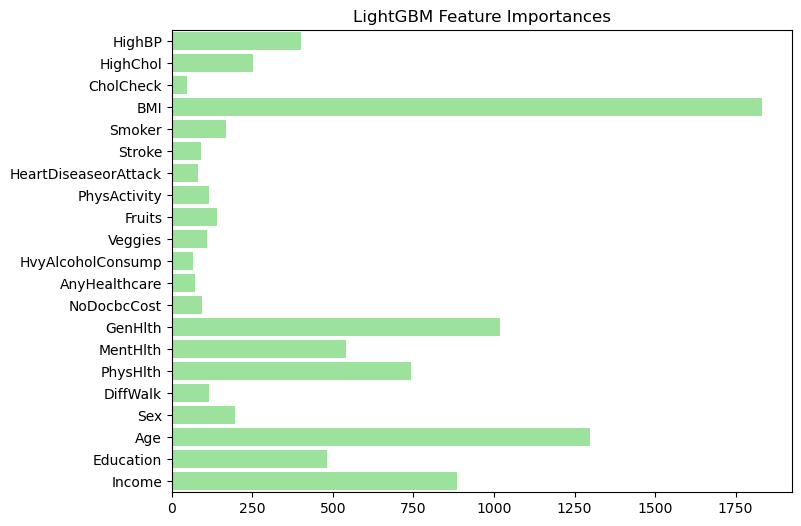

In [43]:
# Feature Importances (Individual Models)
plt.figure(figsize=(8, 6))
best_lgb_model.fit(X_train, y_train)
lgb_importances = best_lgb_model.feature_importances_
lgb_feature_names = X_train.columns
sns.barplot(x=lgb_importances, y=lgb_feature_names, color="lightgreen")
plt.title('LightGBM Feature Importances')
plt.show()

### Ensemble Model 

In [9]:
# Use the best models from previous hyperparameter tuning
best_rf_model = joblib.load('rf_model.pkl')
best_xgb_model = joblib.load('best_xgb_model.pkl')
best_lgb_model = joblib.load('lgb_best_model.pkl')

# Create the VotingClassifier ensemble with best models
ensemble_model = VotingClassifier(estimators=[
    ('xgb', best_xgb_model),
    ('rf', best_rf_model),
    ('lgbm', best_lgb_model)
], voting='soft')  # Use 'soft' voting for probability-based averaging

# Fit the ensemble model on the training data
ensemble_model.fit(X_train, y_train)

# Save the ensemble model
ensemble_model_path = "ensemble_model.pkl"
joblib.dump(ensemble_model, ensemble_model_path)

print(f"Ensemble model saved to {ensemble_model_path}")

[LightGBM] [Info] Number of positive: 152834, number of negative: 152833
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023017 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3960
[LightGBM] [Info] Number of data points in the train set: 305667, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500002 -> initscore=0.000007
[LightGBM] [Info] Start training from score 0.000007
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

### Evaluating Ensemble Model 

In [10]:
# Evaluate on validation set
y_val_pred = ensemble_model.predict(X_val)
y_val_prob = ensemble_model.predict_proba(X_val)[:, 1]  # For ROC-AUC calculation

# Evaluate the ensemble model on validation set
val_accuracy = accuracy_score(y_val, y_val_pred)
val_roc_auc = roc_auc_score(y_val, y_val_prob)
val_classification_rep = classification_report(y_val, y_val_pred)

print(f"Ensemble Validation Accuracy: {val_accuracy}")
print(f"Ensemble Validation ROC-AUC: {val_roc_auc}")
print("Ensemble Classification Report:")
print(val_classification_rep)

Ensemble Validation Accuracy: 0.9210839694656489
Ensemble Validation ROC-AUC: 0.9731278359069985
Ensemble Classification Report:
              precision    recall  f1-score   support

         0.0       0.89      0.97      0.92     32750
         1.0       0.96      0.87      0.92     32750

    accuracy                           0.92     65500
   macro avg       0.92      0.92      0.92     65500
weighted avg       0.92      0.92      0.92     65500



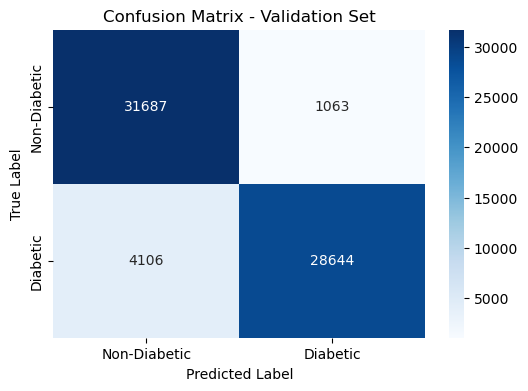

In [11]:
# Confusion Matrix for validation set
val_cm = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(val_cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Non-Diabetic', 'Diabetic'], yticklabels=['Non-Diabetic', 'Diabetic'])
plt.title('Confusion Matrix - Validation Set')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

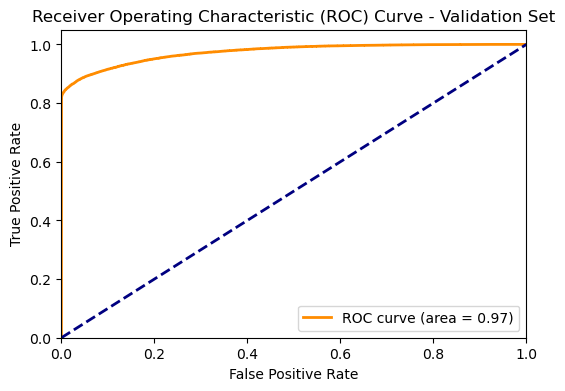

In [12]:
# ROC Curve for validation set
fpr, tpr, _ = roc_curve(y_val, y_val_prob)
val_roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {val_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Validation Set')
plt.legend(loc="lower right")
plt.show()

### Testing Ensemble Model 

In [13]:
# Testing the ensemble model on the test set
y_test_pred = ensemble_model.predict(X_test)
y_test_prob = ensemble_model.predict_proba(X_test)[:, 1]  # For ROC-AUC calculation

# Evaluate the ensemble model on the test set
test_accuracy = accuracy_score(y_test, y_test_pred)
test_roc_auc = roc_auc_score(y_test, y_test_prob)
test_classification_rep = classification_report(y_test, y_test_pred)

print(f"Ensemble Test Accuracy: {test_accuracy}")
print(f"Ensemble Test ROC-AUC: {test_roc_auc}")
print("Ensemble Classification Report for Test Set:")
print(test_classification_rep)

Ensemble Test Accuracy: 0.9224439321537076
Ensemble Test ROC-AUC: 0.9748499389681242
Ensemble Classification Report for Test Set:
              precision    recall  f1-score   support

         0.0       0.89      0.97      0.93     32751
         1.0       0.96      0.88      0.92     32750

    accuracy                           0.92     65501
   macro avg       0.93      0.92      0.92     65501
weighted avg       0.93      0.92      0.92     65501



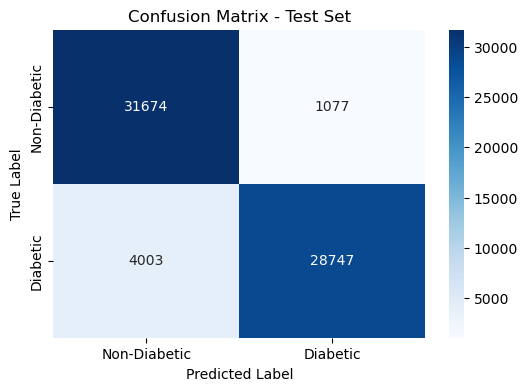

In [14]:
# Confusion Matrix for test set
test_cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(test_cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Non-Diabetic', 'Diabetic'], yticklabels=['Non-Diabetic', 'Diabetic'])
plt.title('Confusion Matrix - Test Set')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

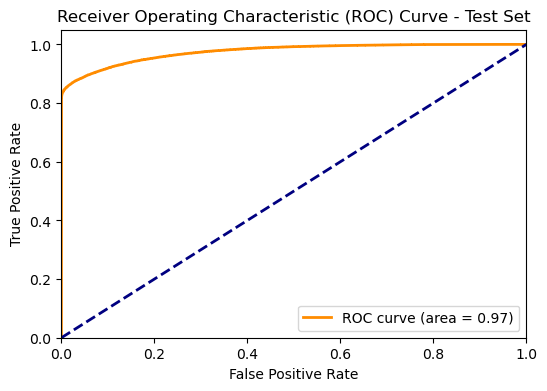

In [15]:
# ROC Curve for test set
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_prob)
test_roc_auc = auc(fpr_test, tpr_test)

plt.figure(figsize=(6, 4))
plt.plot(fpr_test, tpr_test, color='darkorange', lw=2, label=f'ROC curve (area = {test_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Set')
plt.legend(loc="lower right")
plt.show()

[LightGBM] [Info] Number of positive: 152834, number of negative: 152833
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015380 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3960
[LightGBM] [Info] Number of data points in the train set: 305667, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500002 -> initscore=0.000007
[LightGBM] [Info] Start training from score 0.000007
Shape of Random Forest feature importances: (21,)
Shape of XGBoost feature importances: (21,)
Shape of LightGBM feature importances: (21,)


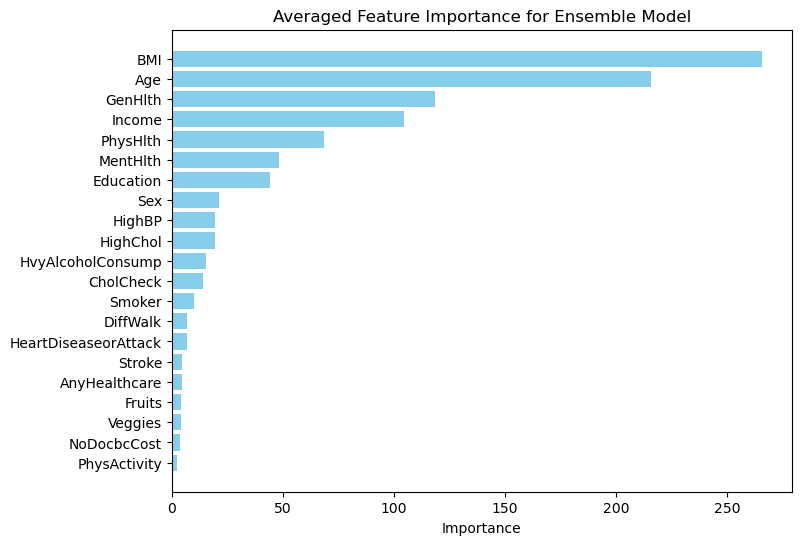

In [56]:
# Ensure models are fitted before accessing feature importances
rf_best_model.fit(X_train, y_train)  # Assuming 'rf_best_model' is RandomForest
xgb_best_model.fit(X_train, y_train)  # Assuming 'xgb_best_model' is XGBoost
lgb_model.fit(X_train, y_train)  # Assuming 'lgb_model' is LightGBM

# Now, get feature importances
rf_importances = rf_best_model.feature_importances_
xgb_importances = xgb_best_model.feature_importances_
lgb_importances = lgb_model.feature_importances_

# Check shapes of feature importances (for debugging purposes)
print(f"Shape of Random Forest feature importances: {rf_importances.shape}")
print(f"Shape of XGBoost feature importances: {xgb_importances.shape}")
print(f"Shape of LightGBM feature importances: {lgb_importances.shape}")

# Ensure models have the same number of features
if rf_importances.shape == xgb_importances.shape == lgb_importances.shape:
    # Now, you can average them
    ensemble_importances = (rf_importances + xgb_importances + lgb_importances) / 3

    # Plot the averaged feature importances
    features = X_train.columns  # Assuming X_train is a DataFrame
    sorted_idx = ensemble_importances.argsort()

    plt.figure(figsize=(8, 6))
    plt.barh(features[sorted_idx], ensemble_importances[sorted_idx], color='skyblue')
    plt.title('Averaged Feature Importance for Ensemble Model')
    plt.xlabel('Importance')
    plt.show()
else:
    print("Error: The models have different numbers of features. Check for feature selection discrepancies.")


### Explainability for Ensemble Model 

In [ ]:
pip install --upgrade imodels

In [58]:
pip install alibi

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [59]:
pip install ALEPython

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement ALEPython (from versions: none)
ERROR: No matching distribution found for ALEPython


In [60]:
pip install dice-ml

Defaulting to user installation because normal site-packages is not writeable
  Obtaining dependency information for pandas<2.0.0 from https://files.pythonhosted.org/packages/da/6d/1235da14daddaa6e47f74ba0c255358f0ce7a6ee05da8bf8eb49161aa6b5/pandas-1.5.3-cp311-cp311-win_amd64.whl.metadata
  Using cached pandas-1.5.3-cp311-cp311-win_amd64.whl.metadata (12 kB)
Using cached pandas-1.5.3-cp311-cp311-win_amd64.whl (10.3 MB)
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.3
    Uninstalling pandas-2.2.3:
      Successfully uninstalled pandas-2.2.3
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\Pir Bakhsh\\AppData\\Roaming\\Python\\Python311\\site-packages\\~andas.libs\\msvcp140-0f2ea95580b32bcfc81c235d5751ce78.dll'
Check the permissions.



In [61]:
pip install interpret

Defaulting to user installation because normal site-packages is not writeable
  Obtaining dependency information for pandas>=0.19.2 from https://files.pythonhosted.org/packages/ed/8c/87ddf1fcb55d11f9f847e3c69bb1c6f8e46e2f40ab1a2d2abadb2401b007/pandas-2.2.3-cp311-cp311-win_amd64.whl.metadata
  Using cached pandas-2.2.3-cp311-cp311-win_amd64.whl.metadata (19 kB)
Using cached pandas-2.2.3-cp311-cp311-win_amd64.whl (11.6 MB)
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.3
    Uninstalling pandas-1.5.3:
      Successfully uninstalled pandas-1.5.3
Note: you may need to restart the kernel to use updated packages.


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dice-ml 0.11 requires pandas<2.0.0, but you have pandas 2.2.3 which is incompatible.


In [17]:
# Import necessary libraries
from sklearn.inspection import permutation_importance, PartialDependenceDisplay
import shap
import lime
import lime.lime_tabular
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
import seaborn as sns
import dice_ml
# from ALEPython import ale_plot
from collections import defaultdict
from alibi.explainers import AnchorTabular
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from interpret.glassbox import ExplainableBoostingClassifier
from interpret import show
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, mean_squared_error, log_loss

import warnings
warnings.filterwarnings("ignore")

## SHAP for XGBoost

In [63]:
# Extract the core booster from the trained XGBoost model
booster = xgb_best_model.get_booster()

# Create the SHAP TreeExplainer using the core booster for XGBoost
explainer_xgb = shap.TreeExplainer(booster)

# Compute SHAP values for binary classification
shap_values_xgb = explainer_xgb.shap_values(X_test)

### Summary Plot (Global Feature Importance)

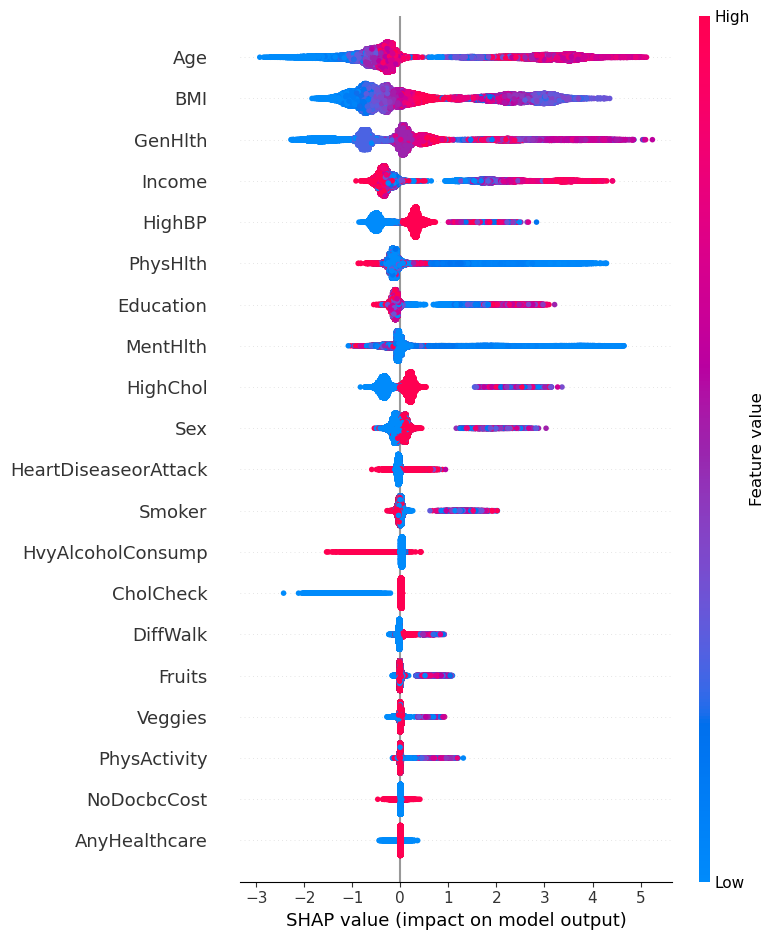

<Figure size 1000x600 with 0 Axes>

In [64]:
# SHAP summary plot for XGBoost (global feature importance)
shap.summary_plot(shap_values_xgb, X_test, feature_names=X_test.columns)

# Optional: Adjust the plot size if necessary
plt.figure(figsize=(10, 6))
plt.show()

### Force Plot (Local Feature Importance for a Specific Instance)

In [65]:
# Initialize JavaScript for SHAP visualizations
shap.initjs()

# SHAP Force Plot for a single instance (local explanation for instance at index 0)
instance_index = 0

# If you used feature selection, `selector.support_` should reflect the selected features
# If not using feature selection, just use X_test.columns
force_plot_xgb = shap.force_plot(
    explainer_xgb.expected_value,  # Model's expected value (base value)
    shap_values_xgb[instance_index],  # SHAP values for the instance
    X_test.iloc[instance_index, :],  # The feature values of the selected instance (use .iloc if X_test is a DataFrame)
    feature_names=X_test.columns  # Modify or remove selector.support_ based on your case
)

# Save the force plot as an HTML file
shap.save_html("xgboost_force_plot_instance_0.html", force_plot_xgb)

# Optional: Display the force plot in a notebook or other environment
force_plot_xgb

### Dependence Plot (Feature Interaction)

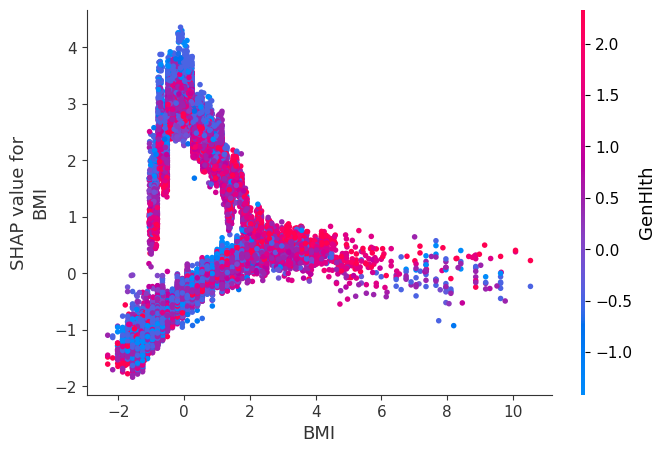

In [66]:
shap.dependence_plot(
    "BMI",  # Name of the feature to analyze
    shap_values_xgb,  # SHAP values for the XGBoost model
    X_test,  # The dataset (use X_test without reduced version unless necessary)
    feature_names=X_test.columns  # Adjust selector.support_ if feature selection is applied
)

### Waterfall Plot (Detailed Breakdown of a Single Prediction)

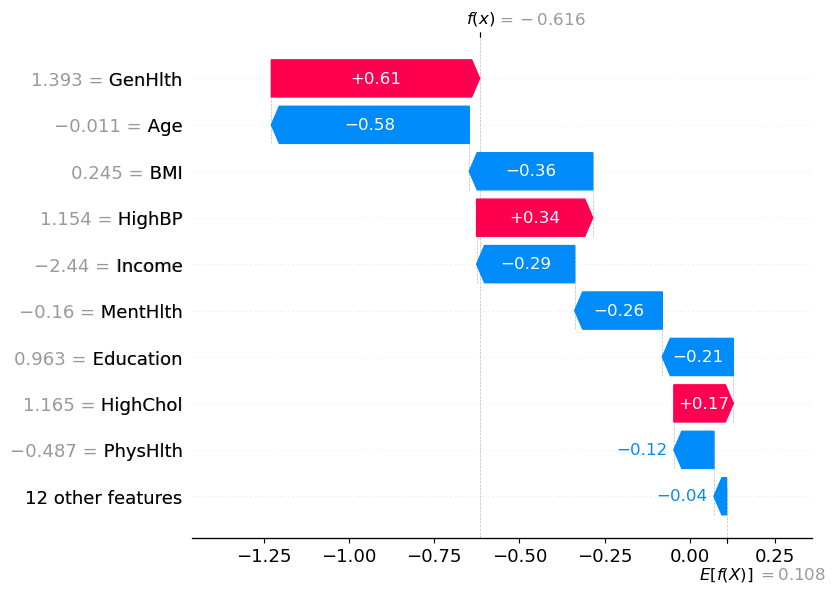

In [67]:
# Define the instance index for which the waterfall plot will be generated
instance_index = 0  # Change this to the desired instance

shap.waterfall_plot(
    shap.Explanation(values=shap_values_xgb[instance_index],  # SHAP values for the instance
                     base_values=explainer_xgb.expected_value,  # Base value (expected value of the model)
                     data=X_test.iloc[instance_index, :],  # Feature values for the selected instance
                     feature_names=X_test.columns)  # Modify if using feature selection
)

### Decision Plot (Cumulative Impact on Prediction)

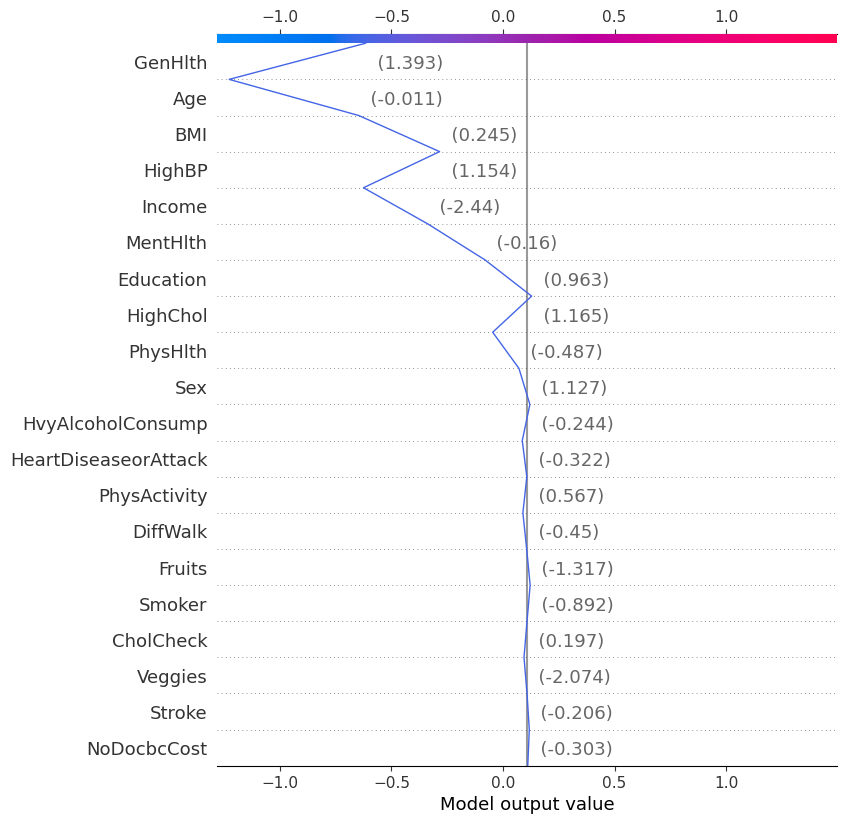

In [68]:
# Define the instance index for which the decision plot will be generated
instance_index = 0  

feature_names = list(X_test.columns)  

shap.decision_plot(
    explainer_xgb.expected_value,  
    shap_values_xgb[instance_index],  
    X_test.iloc[instance_index, :],  
    feature_names=feature_names  
)


## SHAP for Random Forest

In [69]:
# Limit the number of samples to compute SHAP values for (sampling)
X_test_sample = X_test.sample(n=100, random_state=42)  # Limit to 100 samples for faster computation

# Initialize the SHAP TreeExplainer
explainer_rf = shap.TreeExplainer(rf_best_model)  # Assuming rf_best_model is your trained Random Forest model

# Using Approximation to speed up computation
shap_values_rf_approx = explainer_rf.shap_values(X_test_sample, approximate=True)

# Check the shape of the SHAP values for approximation
print(f"Shape of SHAP values (approximation): {np.array(shap_values_rf_approx).shape}")  # Should be (100, 21, 2)

shap_values_rf_class1 = shap_values_rf_approx[:, :, 1]  # Selecting all samples, all features, for class 1

# Debugging: Check the shape of the selected SHAP values
print(f"Shape of SHAP values for class 1: {shap_values_rf_class1.shape}")  # Should be (100, 21)

Shape of SHAP values (approximation): (100, 21, 2)
Shape of SHAP values for class 1: (100, 21)


### Summary Plot (Global Feature Importance)

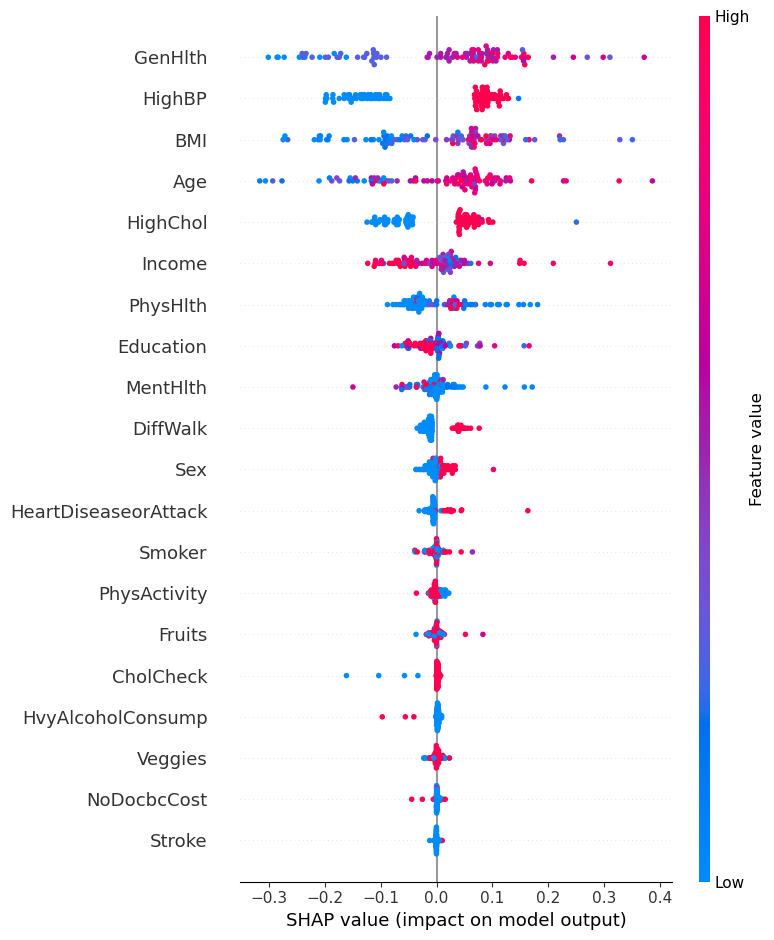

In [70]:
# Now use SHAP plots, e.g., summary plot for class 1
shap.summary_plot(shap_values_rf_class1, X_test_sample, feature_names=X_test.columns)

### Force Plot (Local Feature Importance for a Specific Instance)

In [71]:
# Select an instance index for which you want to generate the force plot
instance_index = 0  # You can change this to any instance you want to explain

shap_values_rf_class1 = shap_values_rf_approx[:, :, 1]  # Selecting SHAP values for class 1

shap.initjs()  # Initialize JavaScript visualization for SHAP plots
force_plot = shap.force_plot(
    explainer_rf.expected_value[1],  # Expected value (base value) for class 1
    shap_values_rf_class1[instance_index],  # SHAP values for the specific instance
    X_test_sample.iloc[instance_index, :]  # Feature values for the selected instance
)

# Save the Force Plot to an HTML file for easy viewing
shap.save_html(f"shap_force_plot_instance_{instance_index}.html", force_plot)

force_plot


### Dependence Plot (Feature Interaction)

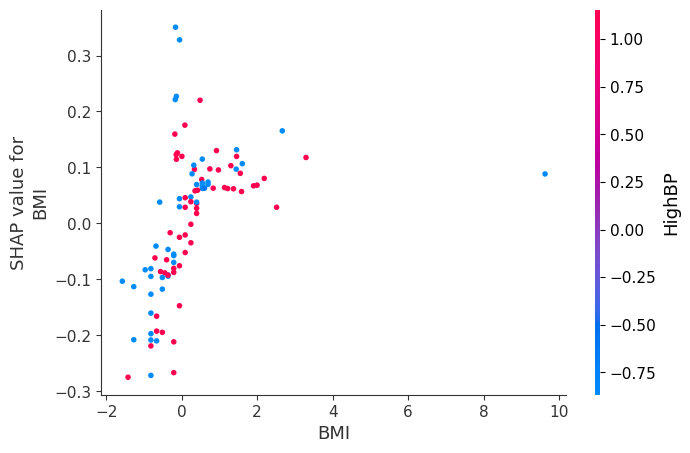

In [72]:
# Ensure SHAP values are calculated for class 1 (positive class)
shap_values_rf_class1 = shap_values_rf_approx[:, :, 1]  # Selecting SHAP values for class 1

shap.dependence_plot(
    "BMI",  
    shap_values_rf_class1,  # SHAP values for class 1
    X_test_sample,  # The feature values
    feature_names=X_test_sample.columns  # Feature names
)


### Waterfall Plot (Detailed Breakdown of a Single Prediction)

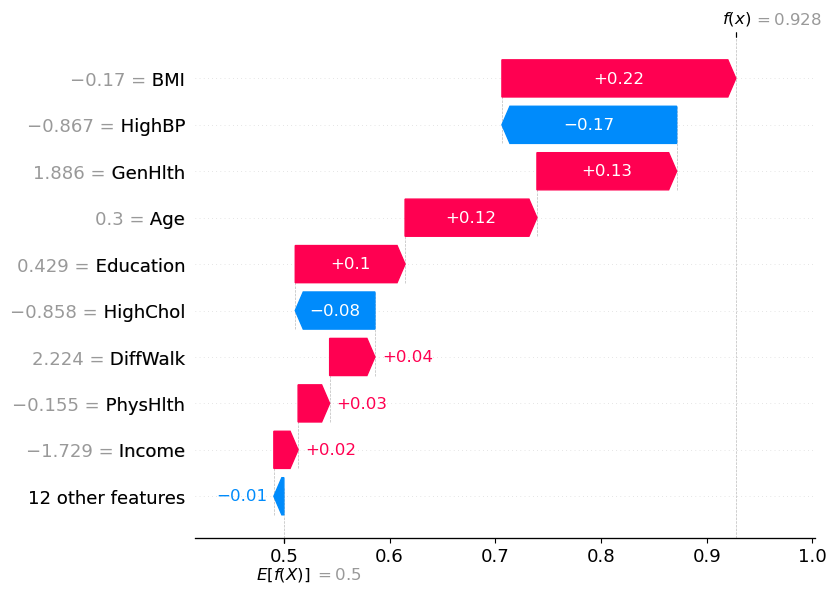

In [73]:
instance_index = 0  

shap_values_rf_class1 = shap_values_rf_approx[:, :, 1]  

shap.waterfall_plot(
    shap.Explanation(
        values=shap_values_rf_class1[instance_index],  # SHAP values for the specific instance
        base_values=explainer_rf.expected_value[1],  # Base value (expected model output for class 1)
        data=X_test_sample.iloc[instance_index, :],  # Feature values for the selected instance
        feature_names=X_test_sample.columns  # Feature names for the plot
    )
)


### Decision Plot (Cumulative Impact on Prediction)

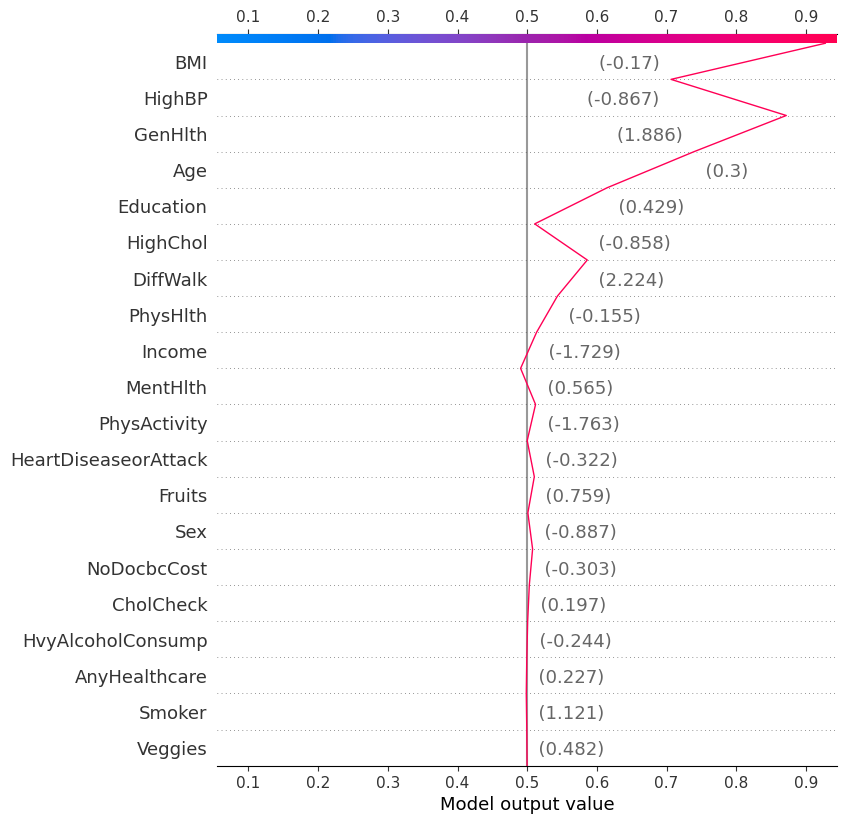

In [74]:
instance_index = 0  

shap_values_rf_class1 = shap_values_rf_approx[:, :, 1]  # Selecting SHAP values for class 1

feature_names_list = list(X_test_sample.columns)

shap.decision_plot(
    explainer_rf.expected_value[1],  # Base value (expected model output for class 1)
    shap_values_rf_class1[instance_index],  # SHAP values for the specific instance
    X_test_sample.iloc[instance_index, :],  # Feature values for the selected instance
    feature_names=feature_names_list  # Convert feature names to a list
)


### SHAP for LighGBM

In [75]:
# Initialize the SHAP TreeExplainer using the best LightGBM model from Grid Search
explainer_lgb = shap.TreeExplainer(grid_search_lgb.best_estimator_)  # Use the best model from grid search

# Compute SHAP values for the test set
shap_values_lgb = explainer_lgb.shap_values(X_test)

C:\Users\Pir Bakhsh\AppData\Roaming\Python\Python311\site-packages\shap\explainers\_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


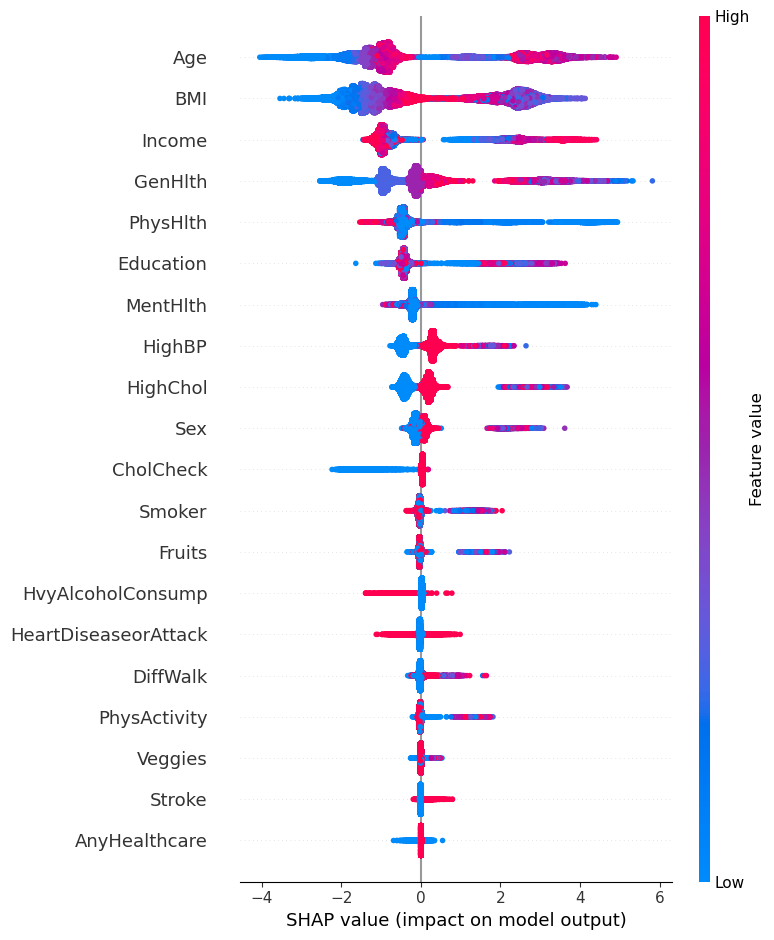

In [76]:
shap.summary_plot(shap_values_lgb, X_test, feature_names=X_test.columns)

In [77]:
instance_index = 0  # Change this to the index of the instance you want to explain

if isinstance(shap_values_lgb, list):
    shap_values_lgb_class1 = shap_values_lgb[1]  # Select SHAP values for class 1
else:
    shap_values_lgb_class1 = shap_values_lgb  # If it's not a list, use the values directly

print(f"SHAP values for class 1 (expected shape: (n_samples, n_features)): {shap_values_lgb_class1.shape}")

shap_values_instance = shap_values_lgb_class1[instance_index]  # SHAP values for the specific instance
feature_values_instance = X_test.iloc[instance_index, :].values  # Feature values for the selected instance

base_value_lgb = explainer_lgb.expected_value if not isinstance(explainer_lgb.expected_value, list) else explainer_lgb.expected_value[1]

shap.initjs()  # Initialize JS visualization for SHAP
force_plot_lgb = shap.force_plot(
    base_value_lgb,  # The base value (scalar for class 1)
    shap_values_instance,  # SHAP values for the specific instance (array)
    feature_values_instance,  # Feature values for the instance (array)
    feature_names=X_test.columns.tolist()  # Feature names converted to a list
)

shap.save_html(f"lgbm_force_plot_instance_{instance_index}.html", force_plot_lgb)

force_plot_lgb

SHAP values for class 1 (expected shape: (n_samples, n_features)): (65501, 21)


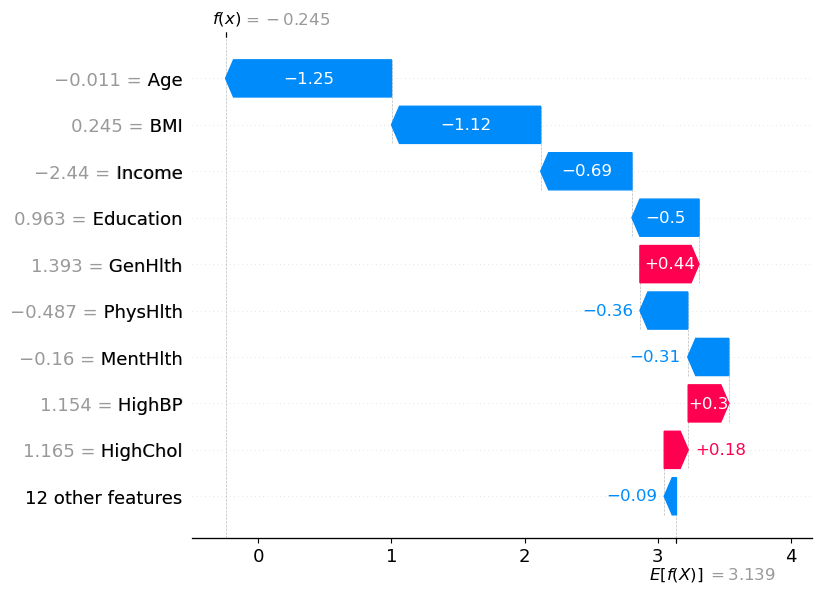

In [78]:
if isinstance(shap_values_lgb, list):
    shap_values_lgb_class1 = shap_values_lgb[1]  # Select SHAP values for class 1
else:
    shap_values_lgb_class1 = shap_values_lgb  # If it's not a list, use the values directly

shap.waterfall_plot(
    shap.Explanation(
        values=shap_values_lgb_class1[instance_index],  # SHAP values for class 1 for the specific instance
        base_values=explainer_lgb.expected_value,  # Base value for the prediction (scalar)
        data=X_test.iloc[instance_index, :],  # Feature values for the selected instance
        feature_names=X_test.columns  # Feature names
    )
)


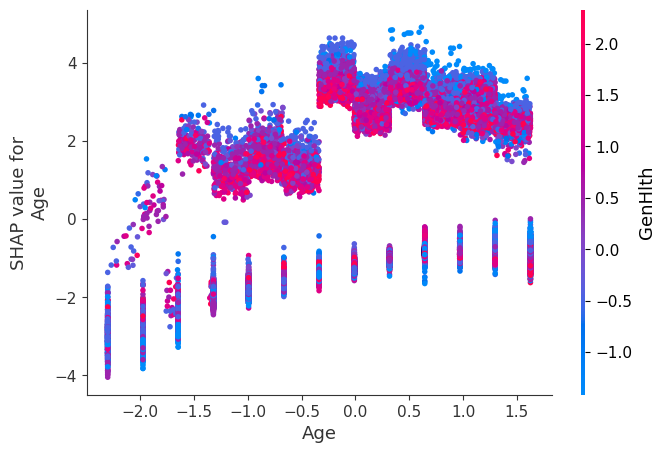

In [80]:
# Define a feature to plot (replace 'Age' with your desired feature)
feature_to_plot = 'Age'  # Example feature, you can change this to any other feature from X_test.columns

# If shap_values_lgb is a list, select SHAP values for class 1
if isinstance(shap_values_lgb, list):
    shap_values_lgb_class1 = shap_values_lgb[1]  # Select SHAP values for class 1
else:
    shap_values_lgb_class1 = shap_values_lgb  # If not a list, use directly

# Create SHAP dependence plot
shap.dependence_plot(
    feature_to_plot,  # Name of the feature for the x-axis
    shap_values_lgb_class1,  # SHAP values for class 1
    X_test,  # Test set (feature values)
    feature_names=X_test.columns  # Feature names for labeling the plot
)

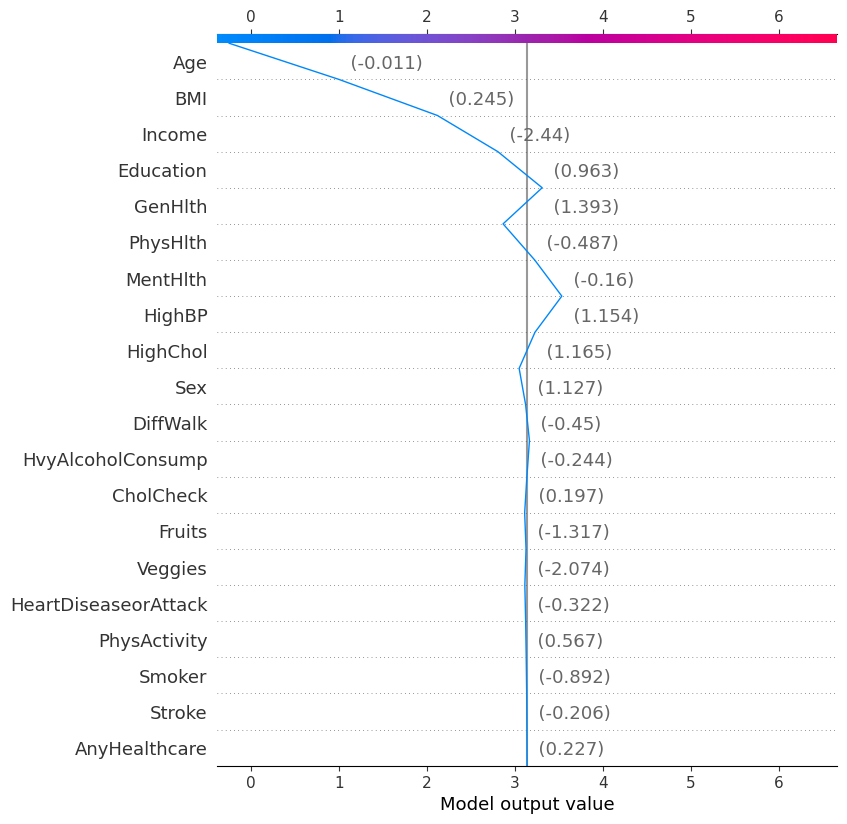

In [81]:
if isinstance(shap_values_lgb, list):
    shap_values_lgb_class1 = shap_values_lgb[1]  # SHAP values for class 1
else:
    shap_values_lgb_class1 = shap_values_lgb  # Use directly if not a list

shap.decision_plot(
    explainer_lgb.expected_value,  # Use base value directly (scalar)
    shap_values_lgb_class1[instance_index],  # SHAP values for the selected instance
    X_test.iloc[instance_index, :],  # Feature values for the selected instance
    feature_names=list(X_test.columns)  # Feature names for labeling
)

## Lime for Ensemble Model 

### LIME Explanation Plot for a Specific Instance

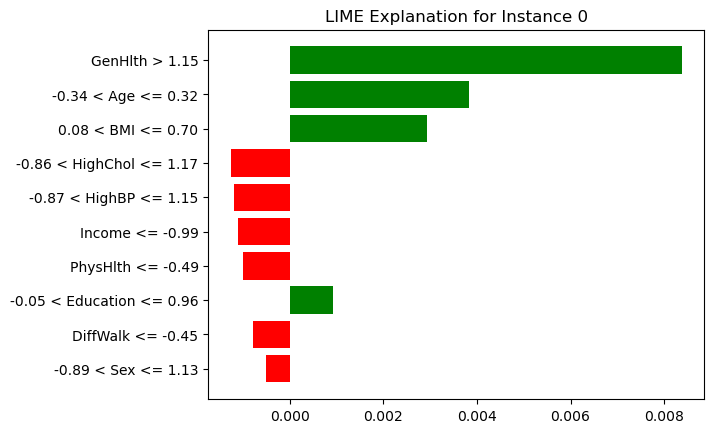

In [19]:
# Initialize the LIME explainer for the ensemble model
lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train),  # Convert to numpy array if necessary
    feature_names=X_train.columns,
    class_names=['Non-Diabetic', 'Diabetic'],  # Adjust class names based on your dataset
    mode='classification'
)

instance_index = 0
instance_data = X_test.iloc[instance_index, :]

lime_exp = lime_explainer.explain_instance(
    data_row=instance_data,
    predict_fn=ensemble_model.predict_proba
)

lime_exp.as_pyplot_figure()
plt.title(f"LIME Explanation for Instance {instance_index}")
plt.show()

### LIME Explanation as a Table

In [83]:
print("LIME Explanation as Table:")
print(lime_exp.as_list())

lime_exp.save_to_file(f"lime_explanation_instance_{instance_index}.html")

LIME Explanation as Table:
[('GenHlth > 1.15', 0.008962416278680432), ('-0.34 < Age <= 0.32', 0.003638124425014357), ('0.08 < BMI <= 0.70', 0.003136731621963994), ('HvyAlcoholConsump <= -0.24', 0.0019482188820279104), ('-0.87 < HighBP <= 1.15', -0.0014745232766220362), ('-0.86 < HighChol <= 1.17', -0.001273298536444722), ('Income <= -0.99', -0.0010637108698331287), ('PhysHlth <= -0.49', -0.000591352365419681), ('NoDocbcCost <= -0.30', 0.0004399004373604463), ('Stroke <= -0.21', 0.00041828867126115127)]


### Class-Specific Explanation (For Multi-Class Classification)

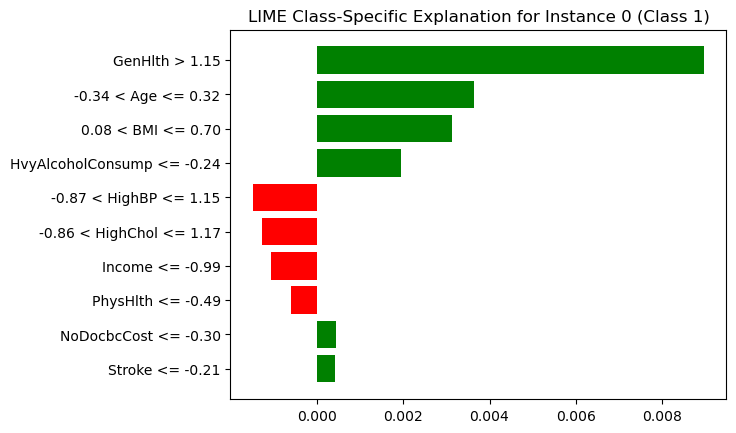

In [84]:
lime_exp.as_pyplot_figure(label=1)  # Class 1 for example ('Diabetic')
plt.title(f"LIME Class-Specific Explanation for Instance {instance_index} (Class 1)")
plt.show()

### Bar Plot for Feature Contributions

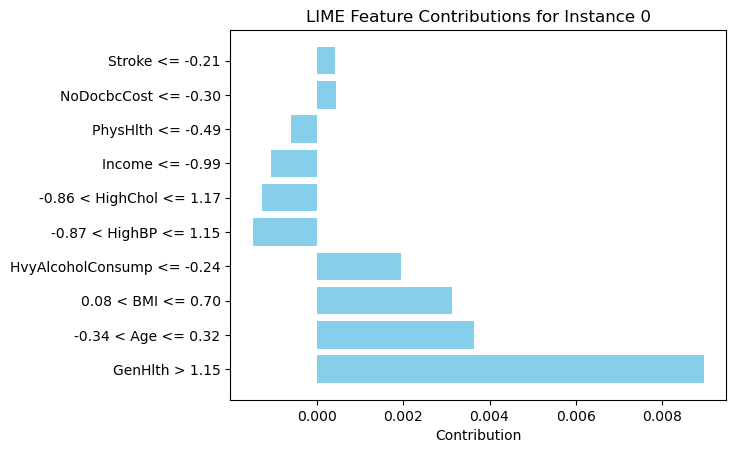

In [85]:
explanation_list = lime_exp.as_list()
features, contributions = zip(*explanation_list)

plt.barh(features, contributions, color="skyblue")
plt.title(f"LIME Feature Contributions for Instance {instance_index}")
plt.xlabel("Contribution")
plt.show()

### Comparing Multiple LIME Explanations

C:\Users\Pir Bakhsh\AppData\Roaming\Python\Python311\site-packages\lime\discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
C:\Users\Pir Bakhsh\AppData\Roaming\Python\Python311\site-packages\lime\discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
C:\Users\Pir Bakhsh\AppData\Roaming\Python\Python311\site-packages\lime\lime_tabular.py:544: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labe

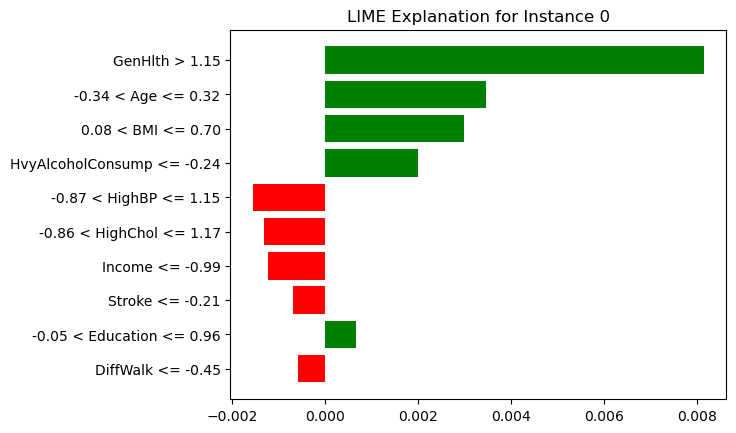

C:\Users\Pir Bakhsh\AppData\Roaming\Python\Python311\site-packages\lime\discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
C:\Users\Pir Bakhsh\AppData\Roaming\Python\Python311\site-packages\lime\discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
C:\Users\Pir Bakhsh\AppData\Roaming\Python\Python311\site-packages\lime\lime_tabular.py:544: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labe

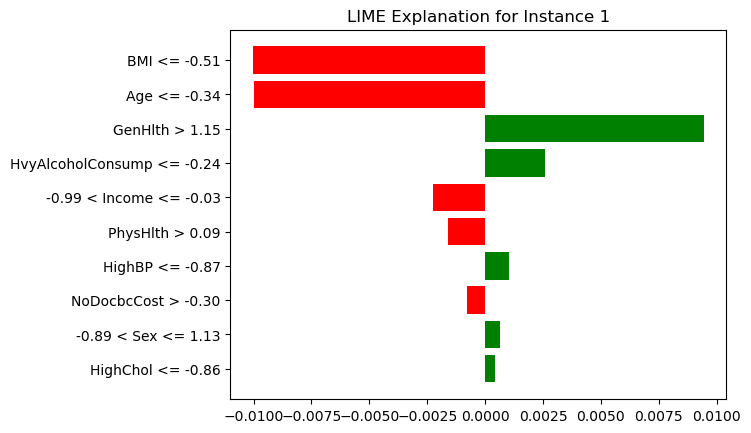

C:\Users\Pir Bakhsh\AppData\Roaming\Python\Python311\site-packages\lime\discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
C:\Users\Pir Bakhsh\AppData\Roaming\Python\Python311\site-packages\lime\discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
C:\Users\Pir Bakhsh\AppData\Roaming\Python\Python311\site-packages\lime\lime_tabular.py:544: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labe

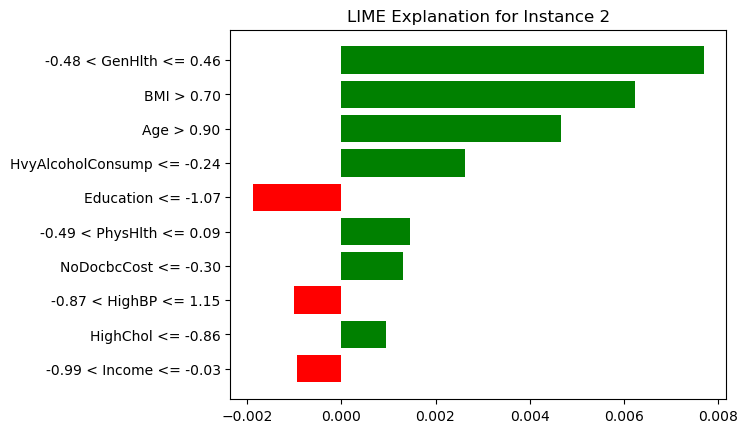

C:\Users\Pir Bakhsh\AppData\Roaming\Python\Python311\site-packages\lime\discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
C:\Users\Pir Bakhsh\AppData\Roaming\Python\Python311\site-packages\lime\discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
C:\Users\Pir Bakhsh\AppData\Roaming\Python\Python311\site-packages\lime\lime_tabular.py:544: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labe

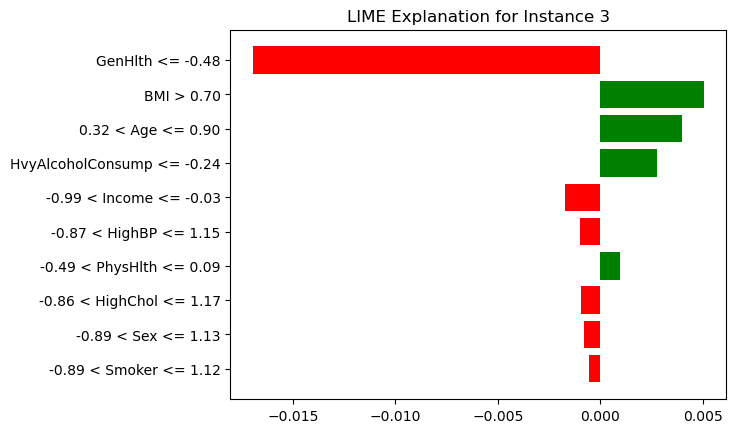

C:\Users\Pir Bakhsh\AppData\Roaming\Python\Python311\site-packages\lime\discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
C:\Users\Pir Bakhsh\AppData\Roaming\Python\Python311\site-packages\lime\discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
C:\Users\Pir Bakhsh\AppData\Roaming\Python\Python311\site-packages\lime\lime_tabular.py:544: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labe

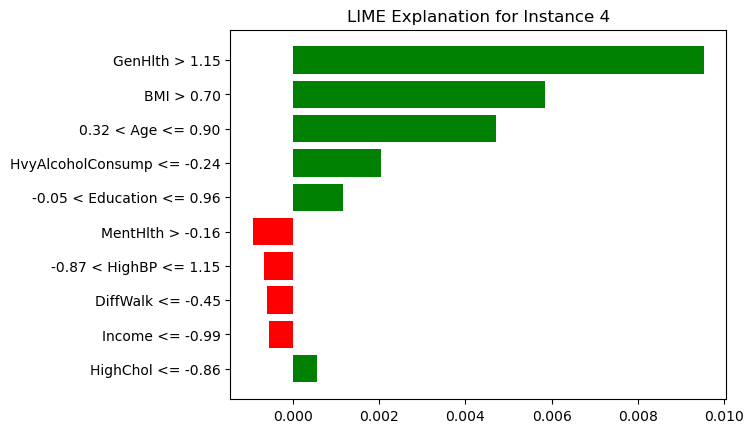

In [86]:
for i in range(5):  # Loop over multiple instances
    instance_data = X_test.iloc[i, :]
    lime_exp = lime_explainer.explain_instance(data_row=instance_data, predict_fn=ensemble_model.predict_proba)
    lime_exp.as_pyplot_figure()
    plt.title(f"LIME Explanation for Instance {i}")
    plt.show()

### Manual Heatmap for Feature Importance Across Multiple Instances

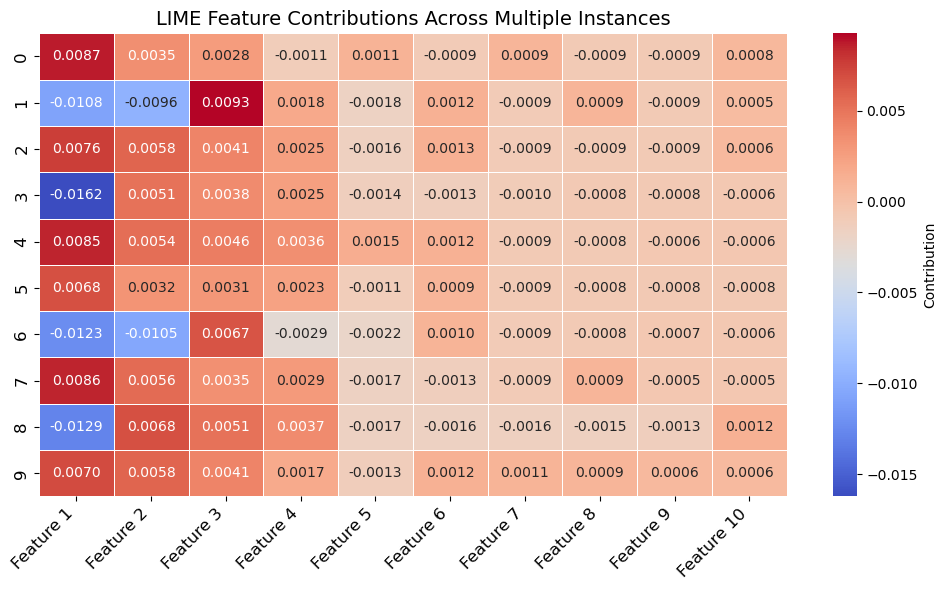

In [99]:
lime_contributions = []
for i in range(10):  # Adjust the range based on how many instances you want to explain
    lime_exp = lime_explainer.explain_instance(data_row=X_test.iloc[i, :], predict_fn=ensemble_model.predict_proba)
    explanation = lime_exp.as_list()
    lime_contributions.append([contribution for _, contribution in explanation])

lime_contributions_df = pd.DataFrame(lime_contributions, columns=[f"Feature {i+1}" for i in range(len(explanation))])

plt.figure(figsize=(10, 6))

sns.heatmap(lime_contributions_df, cmap="coolwarm", annot=True, fmt=".4f", annot_kws={"size": 10}, cbar_kws={'label': 'Contribution'}, linewidths=0.5)

plt.title("LIME Feature Contributions Across Multiple Instances", fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()

plt.show()

### Manual Distribution Plot for Feature Importance Across Instances

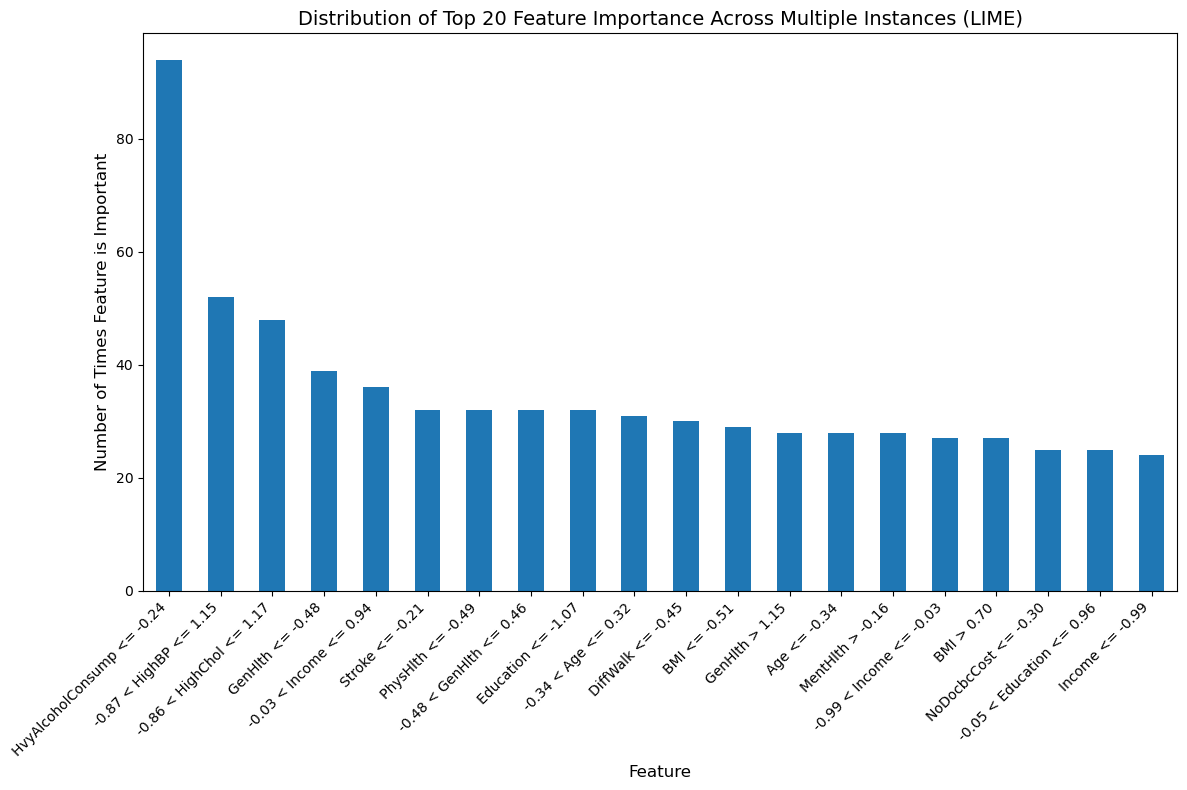

In [100]:
# Import defaultdict from collections
from collections import defaultdict

# Initialize a dictionary to keep track of feature importance counts
feature_importance_counts = defaultdict(int)

for i in range(100):  # Use 100 instances for example
    lime_exp = lime_explainer.explain_instance(data_row=X_test.iloc[i, :], predict_fn=ensemble_model.predict_proba)
    explanation_list = lime_exp.as_list()
    
    for feature, _ in explanation_list:
        feature_importance_counts[feature] += 1

# Convert the feature importance counts to a DataFrame
importance_df = pd.DataFrame(list(feature_importance_counts.items()), columns=['Feature', 'Count'])

# Sort the features by their count and select the top 20
top_features = importance_df.sort_values(by='Count', ascending=False).head(20)

# Plot the top features
plt.figure(figsize=(12, 8))
top_features.plot(kind='bar', x='Feature', y='Count', legend=False, ax=plt.gca())

plt.title("Distribution of Top 20 Feature Importance Across Multiple Instances (LIME)", fontsize=14)
plt.ylabel("Number of Times Feature is Important", fontsize=12)
plt.xlabel("Feature", fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)

plt.tight_layout()
plt.show()


## Permutation Feature Importance for Ensemble Model

Permutation Feature Importance measures the importance of a feature by randomly permuting the values of that feature and observing how it impacts the model’s performance.

In [90]:
perm_importance = permutation_importance(ensemble_model, X_test, y_test, n_repeats=10, random_state=42)

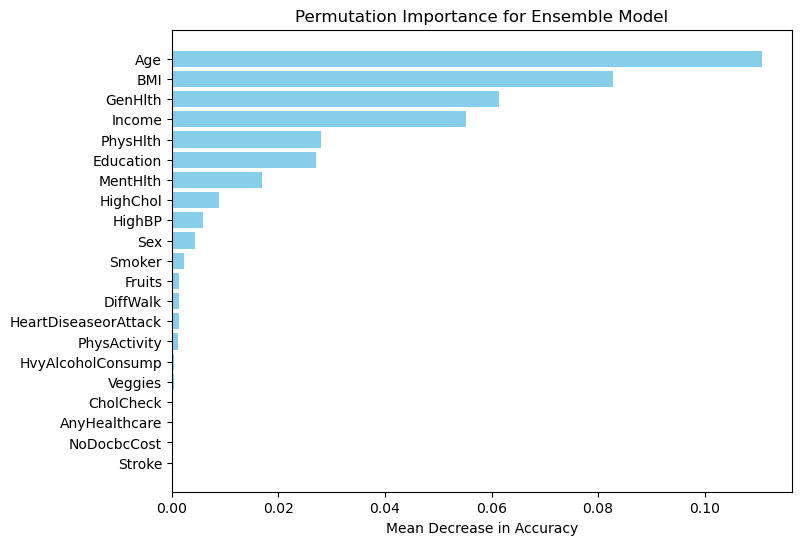

In [91]:
sorted_idx = perm_importance.importances_mean.argsort()
plt.figure(figsize=(8, 6))
plt.barh(X_test.columns[sorted_idx], perm_importance.importances_mean[sorted_idx], color='skyblue')
plt.title('Permutation Importance for Ensemble Model')
plt.xlabel('Mean Decrease in Accuracy')
plt.show()

## Partial Dependence Plot (PDP)

Partial Dependence Plots show the relationship between a feature and the predicted outcome, while keeping other features constant. This gives a visual representation of how individual features impact predictions.

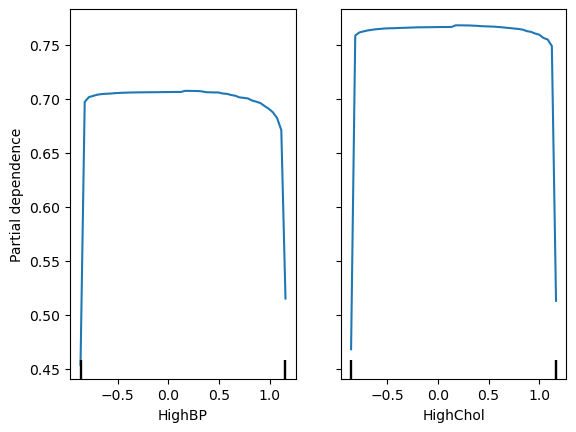

In [92]:
# Select the features for which you want to generate the partial dependence plots
features = [0, 1]  # Replace these with the feature indices or names you're interested in

# Generate partial dependence plots for the selected features
PartialDependenceDisplay.from_estimator(
    ensemble_model,  # Your trained ensemble model
    X_test,  # Test dataset
    features=features,  # Features to plot (either indices or feature names)
    feature_names=X_test.columns,  # Feature names for labeling
    grid_resolution=50  # Increase resolution for smoother curves
)

plt.show()

## ALE Plot (Accumulated Local Effects)

ALE (Accumulated Local Effects) plots are a newer alternative to PDPs. Unlike PDPs, ALE plots account for feature correlations and interactions, making them more robust for highly correlated features.

In [ ]:
ale_plot(X_test, ensemble_model.predict, [0, 1])  # Feature indices

## Counterfactual Explanations

Counterfactual Explanations answer the question: What minimal changes to the input would lead to a different predicted outcome? This is particularly useful for understanding what needs to change in order to achieve a desired prediction.

In [95]:
import dice_ml
from dice_ml.utils import helpers  # Helper functions to load dataset
import pandas as pd
import joblib

# Load the trained ensemble model
ensemble_model_path = "ensemble_model.pkl"
ensemble_model = joblib.load(ensemble_model_path)

# Load the dataset (assuming X_test and y_test are your test sets)
# You should already have X_test and y_test defined

# Step 1: Prepare data for DiCE
# Assuming you are working with a pandas DataFrame, make sure to convert to DataFrame if not
X_test_df = pd.DataFrame(X_test, columns=X_test.columns)

# Concatenate features and target column to form the complete dataframe for DiCE
# Use the correct target column name: 'Diabetes_binary'
data_for_dice = pd.concat([X_test_df, y_test.rename('Diabetes_binary')], axis=1)

# Create a Data Interface for DiCE
data_interface = dice_ml.Data(dataframe=data_for_dice,
                              continuous_features=X_test.columns.tolist(),
                              outcome_name='Diabetes_binary')  # Make sure the target column is correct

# Step 2: Initialize DiCE model for generating counterfactuals
model_interface = dice_ml.Model(model=ensemble_model, backend="sklearn")  # Using scikit-learn backend

# Create the explainer object using model and data
dice_explainer = dice_ml.Dice(data_interface, model_interface)

# Step 3: Generate Counterfactual Explanations
# Select a specific instance from X_test to explain (e.g., the first instance)
instance_index = 0
instance_to_explain = X_test_df.iloc[instance_index:instance_index+1]

# Generate 3 counterfactuals, with the goal to switch to the opposite class ("opposite")
counterfactuals = dice_explainer.generate_counterfactuals(instance_to_explain, 
                                                          total_CFs=3, 
                                                          desired_class="opposite")

# Step 4: Display the counterfactuals
# Visualize the counterfactual explanations
counterfactuals.visualize_as_dataframe()

# Step 5: Save the counterfactuals to a file
counterfactuals_df = counterfactuals.cf_examples_list[0].final_cfs_df
counterfactuals_df.to_csv('counterfactual_explanations.csv', index=False)

print("Counterfactual Explanations saved to 'counterfactual_explanations.csv'")


100%|████████████████████████████████████████| 1/1 [00:00<00:00,  1.01it/s]

Query instance (original outcome : 0.0)


HighBP  HighChol  CholCheck       BMI    Smoker    Stroke  \
0  1.153688  1.165254   0.196922  0.244774 -0.892119 -0.205637   

   HeartDiseaseorAttack  PhysActivity    Fruits   Veggies  ...  NoDocbcCost  \
0             -0.322458      0.567275 -1.316872 -2.074316  ...    -0.303173   

    GenHlth  MentHlth  PhysHlth  DiffWalk       Sex       Age  Education  \
0  1.393207 -0.159827 -0.486592 -0.449718  1.127369 -0.010516   0.963272   

     Income  Diabetes_binary  
0 -2.440138              0.0  

[1 rows x 22 columns]


Diverse Counterfactual set (new outcome: 1.0)


HighBP  HighChol  CholCheck       BMI    Smoker    Stroke  \
0  1.153688  1.165254  -2.893467  0.244774 -0.892119 -0.205637   
1  1.153688  1.165254   0.196922  0.244774 -0.892119 -0.205637   
2  1.153688 -0.205763   0.196922  0.244774 -0.892119  1.258836   

   HeartDiseaseorAttack  PhysActivity    Fruits   Veggies  ...  NoDocbcCost  \
0             -0.322458      0.567275 -1.316872 -0.319785  ...    -0.303173   
1             -0.322458      0.567275 -1.316872 -2.074316  ...    -0.303173   
2             -0.322458      0.567275 -1.316872 -2.074316  ...    -0.303173   

    GenHlth  MentHlth  PhysHlth  DiffWalk       Sex       Age  Education  \
0  1.393207 -0.159827 -0.486592 -0.449718  1.127369 -0.010516   0.963272   
1  1.393207 -0.159827 -0.486592 -0.449718  1.127369 -0.010516   0.963272   
2  1.393207 -0.159827 -0.486592 -0.449718  1.127369 -0.010516   0.963272   

     Income  Diabetes_binary  
0 -2.440138              1.0  
1 -0.965031              1.0  
2 -2.440138              1.0  

[3 rows x 22 columns]

Counterfactual Explanations saved to 'counterfactual_explanations.csv'


## Anchors

Anchors are a type of rule-based explanation method where the model returns high-precision rules (anchors) that explain a prediction. These rules provide conditions under which the prediction is made with high confidence.

In [101]:
# Define the prediction function for the ensemble model
predict_fn = lambda x: ensemble_model.predict(x)

# Initialize an Anchor explainer with the model's predict function
explainer = AnchorTabular(predict_fn, feature_names=X_train.columns.tolist())

# Fit the explainer to the training data
explainer.fit(X_train.values)

# Explain a specific instance
explanation = explainer.explain(X_test.iloc[0].values)

# Display the anchor explanation and precision
print("Anchor Explanation:", explanation.anchor)
print(f"Precision: {explanation.precision:.2f}")


Could not find an anchor satisfying the 0.95 precision constraint. Now returning the best non-eligible result. The desired precision threshold might not be achieved due to the quantile-based discretisation of the numerical features. The resolution of the bins may be too large to find an anchor of required precision. Consider increasing the number of bins in `disc_perc`, but note that for some numerical distribution (e.g. skewed distribution) it may not help.


Anchor Explanation: ['Fruits <= -1.32', 'PhysHlth <= -0.49', 'Age <= 0.32', 'BMI <= 0.70', 'HeartDiseaseorAttack <= -0.32', 'NoDocbcCost <= -0.30']
Precision: 0.88


In [102]:
for i in range(5):  # Change the range as needed
    explanation = explainer.explain(X_test.iloc[i].values)
    print(f"Instance {i+1} Anchor Explanation: {explanation.anchor}")
    print(f"Precision: {explanation.precision:.2f}\n")

Could not find an anchor satisfying the 0.95 precision constraint. Now returning the best non-eligible result. The desired precision threshold might not be achieved due to the quantile-based discretisation of the numerical features. The resolution of the bins may be too large to find an anchor of required precision. Consider increasing the number of bins in `disc_perc`, but note that for some numerical distribution (e.g. skewed distribution) it may not help.


Instance 1 Anchor Explanation: ['PhysActivity <= 0.57', 'PhysHlth <= -0.49', 'Age <= 0.32', 'BMI <= 0.70', 'Smoker <= -0.89', 'Income <= 0.94', 'AnyHealthcare <= 0.23', 'HighChol <= 1.17', 'Veggies <= 0.48', 'Sex <= 1.13', 'HighBP <= 1.15', 'DiffWalk <= 2.22', 'Fruits <= 0.76', 'HeartDiseaseorAttack <= -0.32']
Precision: 0.88



Could not find an anchor satisfying the 0.95 precision constraint. Now returning the best non-eligible result. The desired precision threshold might not be achieved due to the quantile-based discretisation of the numerical features. The resolution of the bins may be too large to find an anchor of required precision. Consider increasing the number of bins in `disc_perc`, but note that for some numerical distribution (e.g. skewed distribution) it may not help.


Instance 2 Anchor Explanation: ['GenHlth > 0.46', 'PhysHlth > 0.09', 'Age <= 0.90', '-1.07 < Education <= -0.05', '-0.99 < Income <= -0.03', 'HvyAlcoholConsump <= -0.24', 'Sex > -0.89', '-0.89 < Smoker <= 1.12', 'Fruits <= -1.32', 'AnyHealthcare <= 0.23', 'HighBP <= 1.15', 'DiffWalk <= 2.22']
Precision: 0.93

Instance 3 Anchor Explanation: ['Age > -0.34', 'BMI > 0.70', 'GenHlth > -0.48', 'HeartDiseaseorAttack > -0.32', 'Stroke > -0.21', 'HighBP > -0.87']
Precision: 0.99



Could not find an anchor satisfying the 0.95 precision constraint. Now returning the best non-eligible result. The desired precision threshold might not be achieved due to the quantile-based discretisation of the numerical features. The resolution of the bins may be too large to find an anchor of required precision. Consider increasing the number of bins in `disc_perc`, but note that for some numerical distribution (e.g. skewed distribution) it may not help.


Instance 4 Anchor Explanation: ['GenHlth <= -0.48', 'MentHlth <= -0.43', 'HeartDiseaseorAttack <= -0.32', '-1.76 < PhysActivity <= 0.57', 'Age <= 0.90', '-1.32 < Fruits <= 0.76', '-0.99 < Income <= -0.03', 'PhysHlth <= 0.09', '-1.07 < Education <= -0.05', 'Veggies <= 0.48', 'HighBP <= 1.15', 'NoDocbcCost <= -0.30', 'HighChol <= 1.17', 'Stroke <= -0.21', '-0.89 < Smoker <= 1.12', 'DiffWalk <= 2.22', 'AnyHealthcare <= 0.23', 'Sex <= 1.13', 'CholCheck <= 0.20', 'HvyAlcoholConsump <= -0.24', 'BMI > 0.08']
Precision: 0.81

Instance 5 Anchor Explanation: ['Age > 0.32', 'GenHlth > 0.46', 'BMI > 0.70', 'Sex > -0.89']
Precision: 0.97



In [103]:
# Display additional information such as coverage
print(f"Coverage: {explanation.coverage:.2f}")

# Check if there is any additional data in the explanation
if hasattr(explanation, 'data') and 'covered' in explanation.data:
    print("Number of examples covered by the anchor:", len(explanation.data['covered']))

# If the explanation contains predicted label or other metadata, display it
if hasattr(explanation, 'prediction'):
    print(f"Predicted Label: {explanation.prediction}")

Coverage: 0.02


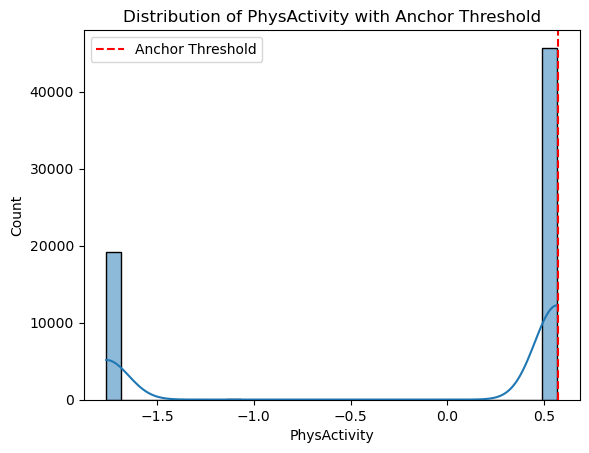

In [104]:
# Example for 'PhysActivity' feature
sns.histplot(X_test['PhysActivity'], bins=30, kde=True)
plt.axvline(x=0.57, color='red', linestyle='--', label='Anchor Threshold')
plt.title('Distribution of PhysActivity with Anchor Threshold')
plt.legend()
plt.show()

## Global Surrogate Models

A global surrogate model is a simpler interpretable model (e.g., decision tree, linear model) that is trained to approximate the predictions of a more complex black-box model. The idea is that the surrogate model gives insight into how the complex model behaves.

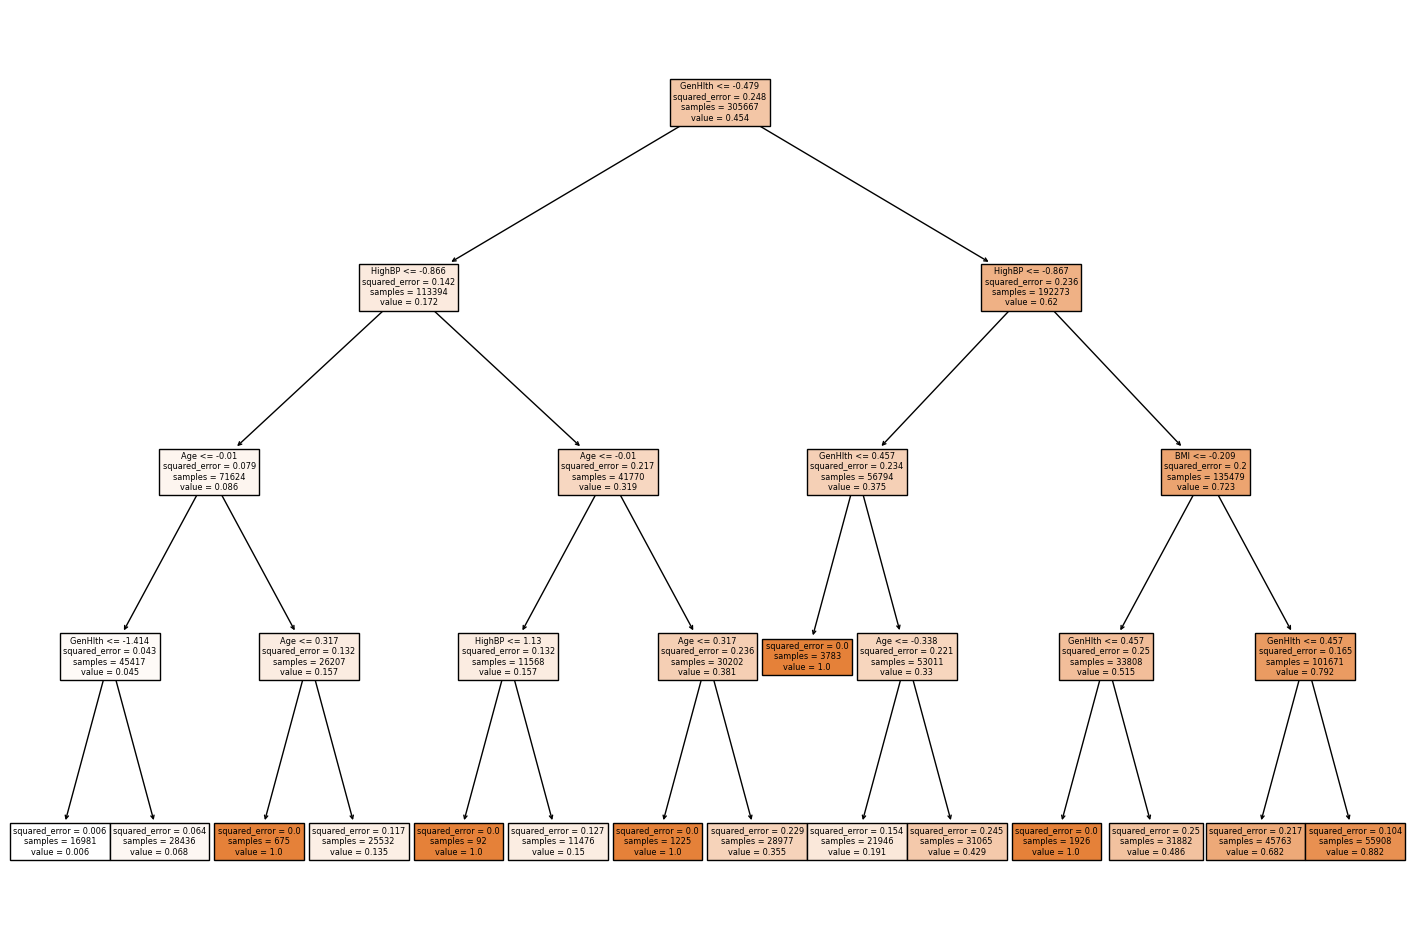

In [105]:
# Train a global surrogate model
surrogate_model = DecisionTreeRegressor(max_depth=4)
surrogate_model.fit(X_train, ensemble_model.predict(X_train))

# Plot the decision tree to understand global model behavior
plt.figure(figsize=(18,12))
tree.plot_tree(surrogate_model, feature_names=X_train.columns.tolist(), filled=True)
plt.show()


## Explainable Boosting Machine (EBM)

EBM is an interpretable machine learning method that provides explanations by construction. It is a type of Generalized Additive Model (GAM) that is easy to interpret but still quite powerful.

In [106]:
# Train an Explainable Boosting Machine
ebm = ExplainableBoostingClassifier()
ebm.fit(X_train, y_train)

# Show global explanations
global_explainer = ebm.explain_global()
show(global_explainer)

<!-- http://127.0.0.1:7001/1729168652560/ -->

## Measuring Explainability Metrics

### Fidelity

Fidelity measures how well the explanation model (like LIME's linear model) approximates the predictions of the original ensemble model. It can be calculated by comparing the predictions of the explanation model (e.g., LIME's surrogate model) with the original model on the same input data.

In [1]:
import numpy as np
from sklearn.metrics import accuracy_score

def calculate_fidelity(lime_explainer, ensemble_model, X_test):
    fidelities = []
    
    for i in range(len(X_test)):  # Loop through multiple instances
        instance_data = X_test.iloc[i, :].values
        # Generate LIME explanation
        lime_exp = lime_explainer.explain_instance(instance_data, predict_fn=ensemble_model.predict_proba)
        
        # Get the prediction from LIME's surrogate model
        lime_pred = np.argmax(lime_exp.local_pred)
        
        # Get the prediction from the original ensemble model (convert to class 0 or 1)
        ensemble_pred = ensemble_model.predict([instance_data.reshape(1, -1)])[0]
        
        # Compare predictions using accuracy (1 if they match, 0 if not)
        fidelity = 1 if lime_pred == ensemble_pred else 0
        fidelities.append(fidelity)
    
    # Return the average fidelity score
    return np.mean(fidelities)

fidelity_score = calculate_fidelity(lime_explainer, ensemble_model, X_test)
print(f"Fidelity: {fidelity_score}")

NameError: name 'lime_explainer' is not defined

In [ ]:
def calculate_shap_fidelity(shap_explainer, ensemble_model, X_test):
    fidelities = []
    
    for i in range(len(X_test)):  # Loop through multiple instances
        instance_data = X_test.iloc[i, :].values.reshape(1, -1)
        
        # Get the original model's prediction
        ensemble_pred = ensemble_model.predict_proba(instance_data)[0].argmax()
        
        # Calculate SHAP values for the instance
        shap_values = shap_explainer.shap_values(instance_data)
        
        # For classification models, shap_explainer.shap_values gives a list of SHAP values
        # for each class, so we pick the SHAP values corresponding to the predicted class.
        shap_pred_class = np.sum(shap_values[ensemble_pred], axis=1) + shap_explainer.expected_value[ensemble_pred]
        
        # Get SHAP-based prediction by taking argmax
        shap_pred_class_label = np.argmax(shap_pred_class)
        
        # Compare predictions
        fidelity = accuracy_score([ensemble_pred], [shap_pred_class_label])
        fidelities.append(fidelity)
    
    return np.mean(fidelities)

# Calculate fidelity for the SHAP explainer
fidelity_score = calculate_shap_fidelity(shap_explainer, ensemble_model, X_test)
print(f"Fidelity: {fidelity_score}")

### Faithfulness

Faithfulness measures how well the explanation reflects the true importance of features in the original model. This can be evaluated by iteratively removing important features and observing the drop in the model’s performance.

In [22]:
from joblib import Parallel, delayed
import numpy as np
from sklearn.metrics import log_loss

def calculate_faithfulness(ensemble_model, X_test, y_test, lime_explainer, num_instances=100):
    base_loss = log_loss(y_test, ensemble_model.predict_proba(X_test))  # Original model loss
    faithfulness_scores = []
    
    for i in range(min(len(X_test), num_instances)):  # Loop through instances
        instance_data = X_test.iloc[i, :]
        
        # Generate LIME explanation for the instance
        lime_exp = lime_explainer.explain_instance(instance_data, predict_fn=ensemble_model.predict_proba)
        
        # Get the most important feature according to LIME
        important_feature_index = lime_exp.local_exp[1][0][0]  # Get the feature index
        important_feature_name = X_test.columns[important_feature_index]  # Get the feature name
        
        # Remove this feature and compute the new prediction
        X_test_modified = X_test.copy()
        X_test_modified[important_feature_name] = 0  # Zero out the most important feature
        
        # Compute the new log loss
        modified_loss = log_loss(y_test, ensemble_model.predict_proba(X_test_modified))
        
        # Compare the drop in performance
        faithfulness_score = modified_loss - base_loss
        faithfulness_scores.append(faithfulness_score)
    
    return np.mean(faithfulness_scores)

faithfulness_score = calculate_faithfulness(ensemble_model, X_test, y_test, lime_explainer, num_instances=100)
print(f"Faithfulness: {faithfulness_score}")

Faithfulness: 0.671091194975129


### Sparsity

Sparsity refers to the number of non-zero feature contributions in an explanation. A sparse explanation contains fewer non-zero values, making it easier to interpret.

In [24]:
def calculate_sparsity(lime_explainer, X_test, num_instances=100):
    sparsities = []
    
    # Process only a subset of instances to avoid excessive computation
    for i in range(min(len(X_test), num_instances)):
        instance_data = X_test.iloc[i, :]
        lime_exp = lime_explainer.explain_instance(instance_data, predict_fn=ensemble_model.predict_proba)
        
        # Get LIME explanation and count the number of non-zero feature contributions
        explanation_list = lime_exp.as_list()
        non_zero_features = len([contrib for _, contrib in explanation_list if contrib != 0])
        sparsities.append(non_zero_features)
    
    return np.mean(sparsities)

# Example usage:
sparsity_score = calculate_sparsity(lime_explainer, X_test, num_instances=100)
print(f"Sparsity: {sparsity_score}")


Sparsity: 10.0


### Stability

Stability measures how consistent the explanation is when small perturbations are added to the input data. A stable explanation should remain similar even with small changes to the input.

In [26]:
def calculate_stability(lime_explainer, ensemble_model, X_test, num_instances=1000, noise_level=0.01):
    stability_scores = []
    
    # Only process a limited number of instances for performance reasons
    for i in range(min(len(X_test), num_instances)):
        instance_data = X_test.iloc[i, :]
        
        # Generate the original LIME explanation
        lime_exp_original = lime_explainer.explain_instance(instance_data, predict_fn=ensemble_model.predict_proba)
        explanation_original = lime_exp_original.as_list()
        
        # Perturb the instance slightly (adding small noise)
        perturbed_instance = instance_data + np.random.normal(0, noise_level, size=instance_data.shape)
        lime_exp_perturbed = lime_explainer.explain_instance(perturbed_instance, predict_fn=ensemble_model.predict_proba)
        explanation_perturbed = lime_exp_perturbed.as_list()
        
        # Compare the explanations using MSE
        original_contribs = [contrib for _, contrib in explanation_original]
        perturbed_contribs = [contrib for _, contrib in explanation_perturbed]
        stability_score = mean_squared_error(original_contribs, perturbed_contribs)
        
        stability_scores.append(stability_score)
    
    return np.mean(stability_scores)

# Example usage:
stability_score = calculate_stability(lime_explainer, ensemble_model, X_test, num_instances=100)
print(f"Stability: {stability_score}")

Stability: 7.42292034017926e-05


### Consistency

Consistency measures how well explanations generalize across different models. For example, do different explanation methods (e.g., LIME, SHAP) agree on the most important features?

In [ ]:
import shap
import numpy as np

# Initialize SHAP explainers for individual models in the ensemble
shap_explainer_rf = shap.TreeExplainer(best_rf_model)
shap_explainer_xgb = shap.TreeExplainer(best_xgb_model)
shap_explainer_lgb = shap.TreeExplainer(best_lgb_model)

# Calculate SHAP values for each model on the test set
shap_values_rf = shap_explainer_rf.shap_values(X_test)
shap_values_xgb = shap_explainer_xgb.shap_values(X_test)
shap_values_lgb = shap_explainer_lgb.shap_values(X_test)

# Average SHAP values across models (assuming binary classification, take the class 1 values)
shap_values_avg = (shap_values_rf[1] + shap_values_xgb[1] + shap_values_lgb[1]) / 3

# Update the function to use these averaged SHAP values
def calculate_consistency(lime_explainer, shap_values_avg, ensemble_model, X_test, num_instances=100, n_jobs=-1):
    def process_instance(i):
        instance_data = X_test.iloc[i, :]
        
        # Generate LIME explanation for the instance
        lime_exp = lime_explainer.explain_instance(instance_data, predict_fn=ensemble_model.predict_proba)
        lime_top_feature = lime_exp.as_list()[0][0]
        
        # Get the top feature from averaged SHAP values
        shap_top_feature = X_test.columns[np.argmax(np.abs(shap_values_avg).mean(0))]

        # Check if LIME and SHAP agree on the most important feature
        consistency_score = 1 if lime_top_feature == shap_top_feature else 0
        return consistency_score

    # Use parallel processing to calculate consistency across multiple instances
    consistency_scores = Parallel(n_jobs=n_jobs)(delayed(process_instance)(i) for i in range(min(len(X_test), num_instances)))

    return np.mean(consistency_scores)

# Now calculate consistency using the averaged SHAP values
consistency_score = calculate_consistency(lime_explainer, shap_values_avg, ensemble_model, X_test, num_instances=100)
print(f"Consistency: {consistency_score}")


## Generalizability of Ensemble Model

In [ ]:
# Make predictions on the training and test sets
y_train_pred = ensemble_model.predict(X_train)
y_test_pred = ensemble_model.predict(X_test)

y_train_prob = ensemble_model.predict_proba(X_train)[:, 1]
y_test_prob = ensemble_model.predict_proba(X_test)[:, 1]

# Accuracy
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

# Precision
train_precision = precision_score(y_train, y_train_pred)
test_precision = precision_score(y_test, y_test_pred)

# Recall
train_recall = recall_score(y_train, y_train_pred)
test_recall = recall_score(y_test, y_test_pred)

# F1-Score
train_f1 = f1_score(y_train, y_train_pred)
test_f1 = f1_score(y_test, y_test_pred)

# ROC-AUC
train_auc = roc_auc_score(y_train, y_train_prob)
test_auc = roc_auc_score(y_test, y_test_prob)

generalizability_accuracy = test_accuracy / train_accuracy
generalizability_precision = test_precision / train_precision
generalizability_recall = test_recall / train_recall
generalizability_f1 = test_f1 / train_f1
generalizability_auc = test_auc / train_auc

print(f"Generalizability Metrics:")
print(f"Accuracy: Training = {train_accuracy:.4f}, Test = {test_accuracy:.4f}, Generalizability = {generalizability_accuracy:.4f}")
print(f"Precision: Training = {train_precision:.4f}, Test = {test_precision:.4f}, Generalizability = {generalizability_precision:.4f}")
print(f"Recall: Training = {train_recall:.4f}, Test = {test_recall:.4f}, Generalizability = {generalizability_recall:.4f}")
print(f"F1-Score: Training = {train_f1:.4f}, Test = {test_f1:.4f}, Generalizability = {generalizability_f1:.4f}")
print(f"ROC-AUC: Training = {train_auc:.4f}, Test = {test_auc:.4f}, Generalizability = {generalizability_auc:.4f}")

In [1]:
pip install nbconvert

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install pytest-playwright

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.6/39.6 MB 676.3 kB/s eta 0:00:0000:0100:02
  Attempting uninstall: python-slugify
    Found existing installation: python-slugify 5.0.2
    Uninstalling python-slugify-5.0.2:
      Successfully uninstalled python-slugify-5.0.2
Note: you may need to restart the kernel to use updated packages.
